# FDS Challenge

This notebook will guide you through the first steps of the competition. Our goal here is to show you how to:

1.  Load the `train.jsonl` and `test.jsonl` files from the competition data.
2.  Create a very simple set of features from the data.
3.  Train a basic model.
4.  Generate a `submission.csv` file in the correct format.
5.  Submit your results.

Let's get started!

# 1. Loading and Inspecting the Data

In [1]:
import json
import pandas as pd
import os

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_data = []

# Read the file line by line
print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")

    # Let's inspect the first battle to see its structure
    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]
        
        # To keep the output clean, we can create a copy and truncate the timeline
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', [])[:2] # Show first 2 turns
        
        # Use json.dumps for pretty-printing the dictionary
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",

# 2. Features Engineering


In [2]:
import numpy as np
from collections import Counter
damage_chart = {
  "normal": {
    "normal": 1,
    "fire": 1,
    "water": 1,
    "electric": 1,
    "grass": 1,
    "ice": 1,
    "fighting": 1,
    "poison": 1,
    "ground": 1,
    "flying": 1,
    "psychic": 1,
    "bug": 1,
    "rock": 0.5,
    "ghost": 0,
    "dragon": 1,
    "dark": 1,
    "steel": 0.5
  },
  "fire": {
    "normal": 1,
    "fire": 0.5,
    "water": 0.5,
    "electric": 1,
    "grass": 2,
    "ice": 2,
    "fighting": 1,
    "poison": 1,
    "ground": 1,
    "flying": 1,
    "psychic": 1,
    "bug": 2,
    "rock": 0.5,
    "ghost": 1,
    "dragon": 0.5,
    "dark": 1,
    "steel": 2
  },
  "water": {
    "normal": 1,
    "fire": 2,
    "water": 0.5,
    "electric": 1,
    "grass": 0.5,
    "ice": 1,
    "fighting": 1,
    "poison": 1,
    "ground": 2,
    "flying": 1,
    "psychic": 1,
    "bug": 1,
    "rock": 2,
    "ghost": 1,
    "dragon": 0.5,
    "dark": 1,
    "steel": 1
  },
  "electric": {
    "normal": 1,
    "fire": 1,
    "water": 2,
    "electric": 0.5,
    "grass": 0.5,
    "ice": 1,
    "fighting": 1,
    "poison": 1,
    "ground": 0,
    "flying": 2,
    "psychic": 1,
    "bug": 1,
    "rock": 1,
    "ghost": 1,
    "dragon": 0.5,
    "dark": 1,
    "steel": 1
  },
  "grass": {
    "normal": 1,
    "fire": 0.5,
    "water": 2,
    "electric": 1,
    "grass": 0.5,
    "ice": 1,
    "fighting": 1,
    "poison": 0.5,
    "ground": 2,
    "flying": 0.5,
    "psychic": 1,
    "bug": 0.5,
    "rock": 2,
    "ghost": 1,
    "dragon": 0.5,
    "dark": 1,
    "steel": 0.5
  },
  "ice": {
    "normal": 1,
    "fire": 0.5,
    "water": 0.5,
    "electric": 1,
    "grass": 2,
    "ice": 0.5,
    "fighting": 1,
    "poison": 1,
    "ground": 2,
    "flying": 2,
    "psychic": 1,
    "bug": 1,
    "rock": 1,
    "ghost": 1,
    "dragon": 2,
    "dark": 1,
    "steel": 0.5
  },
  "fighting": {
    "normal": 2,
    "fire": 1,
    "water": 1,
    "electric": 1,
    "grass": 1,
    "ice": 2,
    "fighting": 1,
    "poison": 0.5,
    "ground": 1,
    "flying": 0.5,
    "psychic": 0.5,
    "bug": 0.5,
    "rock": 2,
    "ghost": 0,
    "dragon": 1,
    "dark": 2,
    "steel": 2
  },
  "poison": {
    "normal": 1,
    "fire": 1,
    "water": 1,
    "electric": 1,
    "grass": 2,
    "ice": 1,
    "fighting": 1,
    "poison": 0.5,
    "ground": 0.5,
    "flying": 1,
    "psychic": 1,
    "bug": 1,
    "rock": 0.5,
    "ghost": 0.5,
    "dragon": 1,
    "dark": 1,
    "steel": 0
  },
  "ground": {
    "normal": 1,
    "fire": 2,
    "water": 1,
    "electric": 2,
    "grass": 0.5,
    "ice": 1,
    "fighting": 1,
    "poison": 2,
    "ground": 1,
    "flying": 0,
    "psychic": 1,
    "bug": 0.5,
    "rock": 2,
    "ghost": 1,
    "dragon": 1,
    "dark": 1,
    "steel": 2
  },
  "flying": {
    "normal": 1,
    "fire": 1,
    "water": 1,
    "electric": 0.5,
    "grass": 2,
    "ice": 1,
    "fighting": 2,
    "poison": 1,
    "ground": 1,
    "flying": 1,
    "psychic": 1,
    "bug": 2,
    "rock": 0.5,
    "ghost": 1,
    "dragon": 1,
    "dark": 1,
    "steel": 0.5
  },
  "psychic": {
    "normal": 1,
    "fire": 1,
    "water": 1,
    "electric": 1,
    "grass": 1,
    "ice": 1,
    "fighting": 2,
    "poison": 2,
    "ground": 1,
    "flying": 1,
    "psychic": 0.5,
    "bug": 1,
    "rock": 1,
    "ghost": 1,
    "dragon": 1,
    "dark": 0,
    "steel": 0.5
  },
  "bug": {
    "normal": 1,
    "fire": 0.5,
    "water": 1,
    "electric": 1,
    "grass": 2,
    "ice": 1,
    "fighting": 0.5,
    "poison": 0.5,
    "ground": 1,
    "flying": 0.5,
    "psychic": 2,
    "bug": 1,
    "rock": 1,
    "ghost": 0.5,
    "dragon": 1,
    "dark": 2,
    "steel": 0.5
  },
  "rock": {
    "normal": 1,
    "fire": 2,
    "water": 1,
    "electric": 1,
    "grass": 1,
    "ice": 2,
    "fighting": 0.5,
    "poison": 1,
    "ground": 0.5,
    "flying": 2,
    "psychic": 1,
    "bug": 2,
    "rock": 1,
    "ghost": 1,
    "dragon": 1,
    "dark": 1,
    "steel": 0.5
  },
  "ghost": {
    "normal": 0,
    "fire": 1,
    "water": 1,
    "electric": 1,
    "grass": 1,
    "ice": 1,
    "fighting": 1,
    "poison": 1,
    "ground": 1,
    "flying": 1,
    "psychic": 2,
    "bug": 1,
    "rock": 1,
    "ghost": 2,
    "dragon": 1,
    "dark": 0.5,
    "steel": 0.5
  },
  "dragon": {
    "normal": 1,
    "fire": 1,
    "water": 1,
    "electric": 1,
    "grass": 1,
    "ice": 1,
    "fighting": 1,
    "poison": 1,
    "ground": 1,
    "flying": 1,
    "psychic": 1,
    "bug": 1,
    "rock": 1,
    "ghost": 1,
    "dragon": 2,
    "dark": 1,
    "steel": 0.5
  },
  "dark": {
    "normal": 1,
    "fire": 1,
    "water": 1,
    "electric": 1,
    "grass": 1,
    "ice": 1,
    "fighting": 0.5,
    "poison": 1,
    "ground": 1,
    "flying": 1,
    "psychic": 2,
    "bug": 1,
    "rock": 1,
    "ghost": 2,
    "dragon": 1,
    "dark": 0.5,
    "steel": 0.5
  },
  "steel": {
    "normal": 1,
    "fire": 0.5,
    "water": 0.5,
    "electric": 0.5,
    "grass": 1,
    "ice": 2,
    "fighting": 1,
    "poison": 1,
    "ground": 1,
    "flying": 1,
    "psychic": 1,
    "bug": 1,
    "rock": 2,
    "ghost": 1,
    "dragon": 1,
    "dark": 1,
    "steel": 0.5
  }
}
def get_defensive_profile(types):
    combined = {}
    for attack_type, defense in damage_chart.items():
        mult = 1.0
        for t in types:
            if attack_type in damage_chart.get(t, {}):
                mult *= damage_chart[t][attack_type]
        combined[attack_type] = mult
    return combined

def compute_battle_meta_features(battle):
    features = {}
    p1_team = battle.get('p1_team_details', [])
    if p1_team:
        ratios = []
        for p in p1_team:
            off = p["base_atk"] + p["base_spa"]
            deff = p["base_def"] + p["base_spd"]
            ratios.append(off / deff if deff > 0 else 0)

        features["avg_type_role_ratio"] = np.mean(ratios)
        features['p1_var_hp'] = np.std([p.get('base_hp', 0) for p in p1_team])
        features['p1_var_spe'] = np.std([p.get('base_spe', 0) for p in p1_team])
        features['p1_var_atk'] = np.std([p.get('base_atk', 0) for p in p1_team])
        features['p1_var_def'] = np.std([p.get('base_def', 0) for p in p1_team])
        p1_types_hp = ([p.get('types', 0) for p in p1_team])
        all_types = [t for pair in p1_types_hp for t in pair if t != 'notype']
        type_counts = Counter(all_types)
        unique_types = len(set(all_types))
        features['diversity_ratio'] = unique_types / 6

        weaknesses, resistances, immunities = [], [], []
        for p in p1_team:
            profile = get_defensive_profile(p["types"])
            w = sum(1 for m in profile.values() if m > 1)
            r = sum(1 for m in profile.values() if 0 < m < 1)
            i = sum(1 for m in profile.values() if m == 0)
            weaknesses.append(w)
            resistances.append(r)
            immunities.append(i)

        features["avg_weaknesses"] = np.mean(weaknesses)
        features["avg_resistances"] = np.mean(resistances)
        features["avg_immunities"] = np.mean(immunities)

    

    
    # --- Player 2 Lead Features ---
    p2_lead = battle.get('p2_lead_details')
    if p2_lead:
        # Player 2's lead Pokémon's stats
        features['p2_lead_hp']= p2_lead.get('base_hp', 0)
        features['p2_lead_spe'] = p2_lead.get('base_spe', 0)
        features['p2_lead_atk'] = p2_lead.get('base_atk', 0)
        features['p2_lead_def'] = p2_lead.get('base_def', 0)

    # T1 prevision
    p_leave = battle.get('battle_timeline', [])
    listz2 = []
    for i, entry in enumerate(p_leave, start=1):
        if entry.get('p2_move_details') is None:
            listz2.append(i)

    batch_1_2 = len([x for x in listz2 if 1 <= x <= 10])
    batch_2_2 = len([x for x in listz2 if 11 <= x <= 20])
    batch_3_2 = len([x for x in listz2 if x > 20])

    listz1 = []
    for i, entry in enumerate(p_leave, start=1):
        if entry.get('p1_move_details') is None:
            listz1.append(i)

    batch_1_1 = len([x for x in listz1 if 1 <= x <= 10])
    batch_2_1 = len([x for x in listz1 if 11 <= x <= 20])
    batch_3_1 = len([x for x in listz1 if x > 20])
    
    features['vol_leave_diff_1']  = batch_1_1 - batch_1_2
    features['vol_leave_diff_2']  = batch_2_1 - batch_2_2
    features['vol_leave_diff_3']  = batch_3_1 - batch_3_2
    
    p_leave = battle.get('battle_timeline', [])
    lista1 = []
    lista2 = []
    count_1_1 = 0
    count_2_1 = 0
    count_1_2 = 0
    count_2_2 = 0
    count_1_3 = 0
    count_2_3 = 0
    for turn in p_leave: 
        lista1.append([turn["p1_pokemon_state"]["name"], turn.get('p1_move_details') == None])

    i = 0
    for x in range(len(lista1) - 1):
        if lista1[i][0] != lista1[i+1][0] and lista1[i+1][1] == False and 1 <= i <= 10:
            count_1_1 +=1
            i +=1
        elif lista1[i][0] != lista1[i+1][0] and lista1[i+1][1] == False and 11 <= i <= 20 :
            count_1_2 +=1
            i +=1
        elif lista1[i][0] != lista1[i+1][0] and lista1[i+1][1] == False and 21 <= i <= 30:
            count_1_3 +=1
            i +=1
        else:
            i +=1 
    
    for turn in p_leave: 
        lista2.append([turn["p2_pokemon_state"]["name"], turn.get('p2_move_details') == None])
    i = 0
    for x in range(len(lista2) - 1):
        if lista2[i][0] != lista2[i+1][0] and lista2[i+1][1] == False and 1 <= i <= 10:
            count_1_2 +=1
            i +=1
        elif lista2[i][0] != lista2[i+1][0] and lista2[i+1][1] == False and 11 <= i <= 20:
            count_2_2 +=1
            i +=1
        elif lista2[i][0] != lista2[i+1][0] and lista2[i+1][1] == False and 21 <= i <= 30:
            count_2_3 +=1
            i +=1
        else:
            i +=1
    
    features['forced_leave_diff_1']  = count_1_1 - count_2_1
    features['forced_leave_diff_2']  = count_1_2 - count_2_2
    features['forced_leave_diff_3']  = count_1_3- count_2_3
                    
    # We also need the ID and the target variable (if it exists)
    features['battle_id'] = battle.get('battle_id')
    if 'player_won' in battle:
        features['player_won'] = int(battle['player_won'])        
    return features


In [3]:
from collections import defaultdict
import numpy as np

# ---------------------------------------------
# Team Winrate Score
# ---------------------------------------------

def _pnames_from_p1_team(record):
    #get names of player1 team
    team = record.get("p1_team_details", []) or []
    names = []
    for p in team:
        if isinstance(p, dict):
            nm = (p.get("name") or "").strip().lower()
            if nm:
                names.append(nm)
    return names

def _pname_from_p2_lead(record):
    #get name of player2 lead
    lead = record.get("p2_lead_details") or {}
    if isinstance(lead, dict):
        nm = (lead.get("name") or "").strip().lower()
        return nm if nm else None
    return None

def build_pokemon_win_stats(train_data, alpha=1.0):
    """
    Build win statistics for each Pokemon.
    We count:
    - games[name]: how many battles the Pokemon played
    - wins[name]:  how many battles the Pokemon won
    We use Laplace smoothing (alpha) to make the win rate more stable when there are few battles.
    """
    #Dictionary to count how many games each Pokemon played
    games = defaultdict(int)
    #Dictionary to count how many wins each Pokemon has
    wins  = defaultdict(int)

    for r in train_data:
        #Get all pokemon names from player1 team
        p1_names = _pnames_from_p1_team(r)
        #Get player2 first pokemon
        p2_lead  = _pname_from_p2_lead(r)
        #Check if Player 1 won this battle (True or False)
        p1_won   = bool(r.get("player_won", False))  # True se ha vinto P1

        #Add +1 game to every Pokemon in Player 1 team
        for nm in p1_names:
            games[nm] += 1
        #Add +1 game to Player 2 lead
        if p2_lead:
            games[p2_lead] += 1

        #If Player 1 won, all his pokemon get +1 win
        if p1_won:
            for nm in p1_names:
                wins[nm] += 1
        else:
            # If Player 2 won, only the lead pokemon gets +1 win
            if p2_lead:
                wins[p2_lead] += 1

    #Now we calculate win-rate with Laplace smoothing
    winrate = {}
    for nm in games:
        g = games[nm] #total games
        w = wins[nm]  #total wins
        #Win rate = (wins + alpha) / (games + 2*alpha)
        wr = (w + alpha) / (g + 2*alpha)  # Laplace: makes the value closer to 0.5 when data is small
        #Save results
        winrate[nm] = {"games": g, "wins": w, "winrate": wr}

    return winrate

def team_score_from_stats(team_names, stats, default_wr=0.5):
    """
    Team score = average win-rate of all pokemon in the team.
    If a pokemon name is not in stats, we use default_wr (0.5).
    """
    vals = []
    for nm in team_names:
        nm = (nm or "").strip().lower()
        if not nm:
            continue
        wr = stats.get(nm, {}).get("winrate", default_wr)
        vals.append(wr)
    return float(np.mean(vals)) if vals else default_wr

def predict_from_stats(test_record, stats, threshold=0.5):
    """
    Predict if Player 1 will win: True if team_score > threshold.
    """
    #Get all pokemon names in player1’s team
    p1_names = _pnames_from_p1_team(test_record)
    #Calculate the average win-rate of player1's team
    score = team_score_from_stats(p1_names, stats, default_wr=0.5)
    
    return (score > threshold), score
    
# ---------------------------------------------
# HP Survival Score
# ---------------------------------------------

def build_pokemon_hp_stats(train_data):
    """Calculate for each Pokémon:
    - how many battles it played
    - the total final HP percentage in all battles
    - the average final HP
    """
    hp_sum = defaultdict(float)
    hp_count = defaultdict(int)

    for r in train_data:
        timeline = r.get("battle_timeline", [])
        if not timeline:
            continue
        
        last_turn = timeline[-1]

        for player_key in ["p1_pokemon_state", "p2_pokemon_state"]:
            name = (last_turn.get(player_key, {}).get("name") or "").strip().lower()
            hp   = last_turn.get(player_key, {}).get("hp_pct", None)

            if name and isinstance(hp, (int, float)):
                hp_sum[name] += float(hp)
                hp_count[name] += 1

    stats = {}
    for name in hp_sum:
        stats[name] = {
            "count": hp_count[name],
            "hp_mean": hp_sum[name] / hp_count[name]
        }
    return stats
    
def team_hp_score(team_names, hp_stats, default_hp=50.0):
    """
    Return the average final HP of a team.

    For each Pokémon in the team:
    - use its average HP from hp_stats if available,
    - otherwise use default_hp.

    This gives a simple measure of how healthy the team usually ends battles.
    """
    hp_values = []
    for name in team_names:
        name = (name or "").strip().lower()
        if name in hp_stats:
            hp_values.append(hp_stats[name]["hp_mean"])
        else:
            hp_values.append(default_hp)
    return np.mean(hp_values) if hp_values else default_hp


# ---------------------------------------------
# Average Damage Score
# ---------------------------------------------

def build_pokemon_avg_damage(train_data):
    """
    Calculate the average damage done by each pokemon in all battle.
    Damage = opponent HP before - opponent HP after.
    """
    total_damage = defaultdict(float) #total damage for each Pokémon
    battles_count = defaultdict(int) #how many battles each Pokémon played

    for battle in train_data:
        timeline = battle.get("battle_timeline", [])
        
        #Player1 team pokemon names
        p1_team = battle.get("p1_team_details", [])
        p1_names = [(p.get("name") or "").lower() for p in p1_team if isinstance(p, dict)]
        
        #Player2's first pokemon (lead) name
        p2_lead = battle.get("p2_lead_details", {})
        p2_name = (p2_lead.get("name") or "").lower() if isinstance(p2_lead, dict) else None

        #Count one battle for each pokemon who appears here
        for name in p1_names:
            battles_count[name] += 1
        if p2_name:
            battles_count[p2_name] += 1

        #Check damage in each turn
        for turn_idx in range(1, len(timeline)):
            prev = timeline[turn_idx - 1]
            curr = timeline[turn_idx]

            #Damage done by Player1 = P2 HP before - P2 HP after
            hp2_before = prev.get("p2_pokemon_state", {}).get("hp_pct", None)
            hp2_after = curr.get("p2_pokemon_state", {}).get("hp_pct", None)

            if isinstance(hp2_before, (int, float)) and isinstance(hp2_after, (int, float)):
                damage = max(0, hp2_before - hp2_after)
                if p1_names and damage > 0:
                    for name in p1_names:
                        total_damage[name] += damage

            #Damage done by Player2 = P1 HP before - P1 HP after
            hp1_before = prev.get("p1_pokemon_state", {}).get("hp_pct", None)
            hp1_after = curr.get("p1_pokemon_state", {}).get("hp_pct", None)

            if isinstance(hp1_before, (int, float)) and isinstance(hp1_after, (int, float)):
                damage = max(0, hp1_before - hp1_after)
                if p2_name and damage > 0:
                    total_damage[p2_name] += damage

    #Average damage = total damage / number of battles
    avg_damage = {
        name: total_damage[name] / battles_count[name]
        for name in battles_count if battles_count[name] > 0
    }

    return avg_damage
    
def damage_feature_for_battle(record, avg_damage):
    """
    Calculate for this battle:
    - total average damage of player1's pokemon
    - total average damage of Player2's pokemon (only the lead)
    - difference between them
    - prediction: 1 if Player1 > Player2, else 0
    """
    #Get names of Player1's team
    p1_team = record.get("p1_team_details", [])
    p1_names = [(p.get("name") or "").lower() for p in p1_team if isinstance(p, dict)]
    #Sum of average damage of Player1's Pokémon
    p1_damage_score = sum(avg_damage.get(name, 0) for name in p1_names)

    #Player2
    p2_lead = record.get("p2_lead_details", {})
    p2_name = (p2_lead.get("name") or "").lower() if isinstance(p2_lead, dict) else None
    #Average damage of that Pokémon
    p2_damage_score = avg_damage.get(p2_name, 0) if p2_name else 0
    #Compare scores
    diff = p1_damage_score - p2_damage_score
    feature = 1.0 if diff > 0 else 0.0 #1 = Player1 stronger, 0 = Player2 stronger

    return {
        "avg_damage_p1": p1_damage_score,   #total average damage of Player1's team
        "avg_damage_p2": p2_damage_score,   #average damage of Player2's lead
        "avg_damage_diff": diff,            #difference between P1 and P2
        "damage_prediction": feature        #final prediction (1 or 0)
    }
    
#Team Winrate Score
POKEMON_STATS = build_pokemon_win_stats(train_data, alpha=1.0) 
#HP Survival Score
POKEMON_HP_STATS = build_pokemon_hp_stats(train_data)
#Average Damage Score
pokemon_avg_damage = build_pokemon_avg_damage(train_data)


In [4]:
def extract_battle_progression_features(r):
    
    tl = get_timeline(r, max_turns=30)
    p1, p2 = _extract_hp_series(tl)
    if "p1_team_details" in r:
        t1 = r["p1_team_details"]
    else:
        t1 = []
    
    if "p2_lead_details" in r:
        lead = r["p2_lead_details"]
    else:
        lead = {}    
    f = {}
    

    #Check if at least 3 turns exist for both players
    if len(p1) >= 3 and len(p2) >= 3:
    
        #Mean HP of the first 3 turns
        media_p1 = sum(p1[:3]) / 3
        media_p2 = sum(p2[:3]) / 3
    
        #Who is winning in the first 3 turns
        if media_p1 > media_p2:
            f['is_p1_higher_avg_hp_after_3_turns'] = 1.0
        else:
            f['is_p1_higher_avg_hp_after_3_turns'] = 0.0
    
        # Difference in HP between the two players
        f['avg_hp_difference_after_3_turns'] = media_p1 - media_p2
    #Does player1 have higher final HP than player2?
    if p1 and p2:
        f['is_player1_final_hp_winner'] = 1.0 if p1[-1] > p2[-1] else 0.0
        f['final_hp_difference'] = p1[-1] - p2[-1]
    

    if len(p1) >= 6 and len(p2) >= 6:
        #Who is in the lead after the first 3 turns?
        player1_advantage_start = np.mean(p1[:3]) > np.mean(p2[:3])
        
        #Who is in the lead in the last 3 turns?
        player1_advantage_end = np.mean(p1[-3:]) > np.mean(p2[-3:])
        
        #Has the lead changed? If yes comeback happened
        f['comeback_happened'] = float(player1_advantage_start != player1_advantage_end)
    #Total sum of base stats for player1's team
    p1_total_stats = sum(p.get('base_hp', 0) + p.get('base_atk', 0) + 
                         p.get('base_def', 0) + p.get('base_spa', 0) + 
                         p.get('base_spd', 0) + p.get('base_spe', 0) 
                         for p in t1 if isinstance(p, dict))
    #Total sum of base stats for player2's team
    p2_total_stats = (lead.get('base_hp', 0) + lead.get('base_atk', 0) + 
                      lead.get('base_def', 0) + lead.get('base_spa', 0) + 
                      lead.get('base_spd', 0) + lead.get('base_spe', 0))
    
    # 1 = player1 has higher total stats, else 0
    f['stronger_team'] = 1.0 if p1_total_stats > p2_total_stats else 0.0
    #Difference between the total stats of the two players
    f['team_strength_gap'] = p1_total_stats - p2_total_stats

    #get all speed values of player 1 Pokémon
    p1_speeds = [p.get('base_spe', 0) for p in t1 if isinstance(p, dict)]
    #get speed of player 2 lead Pokémon
    p2_speed = lead.get('base_spe', 0) if isinstance(lead, dict) else 0
    
    if p1_speeds:
        #1 = player1 is faster, 0 = player2 is faster or same
        f['faster_team'] = 1.0 if max(p1_speeds) > p2_speed else 0.0
        #how much faster (best speed of p1 - speed of p2)
        f['speed_advantage'] = max(p1_speeds) - p2_speed
        #count how many p1 Pokémon are faster than p2 lead
        f['num_faster_pokemon'] = sum(1 for s in p1_speeds if s > p2_speed)
    #if player1 has no Pokémon    
    else:
        f['faster_team'] = 0.0
        f['speed_advantage'] = 0.0
        f['num_faster_pokemon'] = 0.0
   #p1_powers and p2_powers contain the list of all move power values (base_power) used by player1 and player2 during the battle 
    p1_powers = []
    p2_powers = []
    
    for t in tl:
        if not isinstance(t, dict):
            continue
        
        md1 = t.get('p1_move_details')
        if isinstance(md1, dict):
            bp1 = md1.get('base_power')
            if isinstance(bp1, (int, float)) and bp1 > 0:
                p1_powers.append(float(bp1))
        
        md2 = t.get('p2_move_details')
        if isinstance(md2, dict):
            bp2 = md2.get('base_power')
            if isinstance(bp2, (int, float)) and bp2 > 0:
                p2_powers.append(float(bp2))
    #Check who has stronger moves on average.
    #'most_avg_powerful_move' = 1 if Player 1 has higher average move power.
    #'avg_move_power_difference' = avg power of Player 1 moves minus Player 2 moves.
    if p1_powers and p2_powers:
        f['most_avg_powerful_move'] = 1.0 if np.mean(p1_powers) > np.mean(p2_powers) else 0.0
        f['avg_move_power_difference'] = np.mean(p1_powers) - np.mean(p2_powers)
    else:
        f['most_avg_powerful_move'] = 0.0
        f['avg_move_power_difference'] = 0.0
    #Count how many turns each player had low HP (below 25%)
    #check who was in danger fewer times and measure how long the battle lasted.
    f['p1_low_hp_count'] = sum(1 for hp in p1 if 0 < hp < 25)
    f['p2_low_hp_count'] = sum(1 for hp in p2 if 0 < hp < 25)
    f['is_player1_less_time_in_danger'] = 1.0 if f['p1_low_hp_count'] < f['p2_low_hp_count'] else 0.0
    #Battle duration and "long battle" flag (more than 15 turns)
    f['battle_length'] = len(tl)
    f['long_battle'] = 1.0 if len(tl) > 15 else 0.0
    #Check HP stability:
    #Calculate how much HP changes from one turn to the next
    #Smaller changes = more stable HP
    #Save average stability for both players and who is more stable
    if len(p1) > 1 and len(p2) > 1:
        p1_changes = [abs(p1[i] - p1[i-1]) for i in range(1, len(p1))]
        p2_changes = [abs(p2[i] - p2[i-1]) for i in range(1, len(p2))]
        
        f['p1_hp_stability'] = -np.mean(p1_changes) if p1_changes else 0.0
        f['p2_hp_stability'] = -np.mean(p2_changes) if p2_changes else 0.0
        f['more_stable_hp'] = 1.0 if (p1_changes and p2_changes and 
                                      np.mean(p1_changes) < np.mean(p2_changes)) else 0.0
    else:
        f['p1_hp_stability'] = 0.0
        f['p2_hp_stability'] = 0.0
        f['more_stable_hp'] = 0.0
    #First KO analysis (who knocks out first)
    p1_first_ko = 0.0
    p2_first_ko = 0.0
    for i, (hp1, hp2) in enumerate(zip(p1, p2)):
        if hp2 == 0 and p2_first_ko == 0.0:
            p2_first_ko = 1.0
            break
        if hp1 == 0 and p1_first_ko == 0.0:
            p1_first_ko = 1.0
            break
    
    f['player1_got_first_ko'] = p2_first_ko  #1 = Player 1 made first KO
    f['player1_suffered_first_ko'] = p1_first_ko #1 = Player 1 was KO'd first
    
    p1_types = set()
    for p in t1:
        if not isinstance(p, dict):
            continue
        types = p.get('types', [])
        if isinstance(types, str):
            types = [types]
        p1_types.update(t for t in types if t)
    #Number of different types in the team
    f['number_different_types'] = len(p1_types)
    #1 if team has at least 4 different types else 0
    f['team_has_type_variety'] = 1.0 if len(p1_types) >= 4 else 0.0
    
    #Calculate % of turns where each player had more than 50% HP
    if p1 and p2:
        p1_healthy_ratio = sum(1 for hp in p1 if hp > 50) / len(p1)
        p2_healthy_ratio = sum(1 for hp in p2 if hp > 50) / len(p2)
        f['p1_hp_over_50_ratio'] = p1_healthy_ratio
        f['p2_hp_over_50_ratio'] = p2_healthy_ratio
        #1 if Player 1 stayed healthier for more turns than Player 2
        f['is_player1_healthier'] = 1.0 if p1_healthy_ratio > p2_healthy_ratio else 0.0
    else:
        f['p1_hp_over_50_ratio'] = 0.0
        f['p2_hp_over_50_ratio'] = 0.0
        f['is_player1_healthier'] = 0.0
        
    #Count how many turns Player 1 has more HP than Player 2
    if len(p1) == len(p2) and p1:
        turns_ahead = sum(1 for hp1, hp2 in zip(p1, p2) if hp1 > hp2)
        #Save total turns in advantage
        f['turns_in_lead'] = turns_ahead
        #Ratio of turns with advantage
        f['lead_ratio'] = turns_ahead / len(p1)
        #Did player1 dominate the battle? (more than 70% of turns in lead)
        f['dominated_battle'] = 1.0 if turns_ahead > len(p1) * 0.7 else 0.0
    else:
        f['turns_in_lead'] = 0.0
        f['lead_ratio'] = 0.0
        f['dominated_battle'] = 0.0
    p_leave = r.get('battle_timeline', [])
    
    if p_leave:
        lista = []
        count_1 = 0
        count_2 = 0
        for turn in p_leave:
            lista.append([
                turn.get("p1_pokemon_state", {}).get("name"),
                turn.get('p1_move_details') is None,
                turn.get("p2_pokemon_state", {}).get("name"),
                turn.get('p2_move_details') is None
            ])
        
        for i in range(len(lista) - 1):
            if lista[i+1][0] != lista[i][0] and lista[i+1][1] == False:
                count_1 += 1
            elif lista[i+1][2] != lista[i][2] and lista[i+1][3] == False:
                count_2 += 1
        #Number of times Player1 was forced to switch pokemon minus Player2 (positive means P1 more forced switches)
        f['forced_pokemon_switch_diff'] = count_1 - count_2
    else:
        f['forced_pokemon_switch_diff'] = 0
    #Count how many different Pokémon were used by each player
    if p_leave:
        p1_pokemon_names = set([turn.get("p1_pokemon_state", {}).get("name") 
                                for turn in p_leave 
                                if turn.get("p1_pokemon_state", {}).get("name")])
        p2_pokemon_names = set([turn.get("p2_pokemon_state", {}).get("name") 
                                for turn in p_leave 
                                if turn.get("p2_pokemon_state", {}).get("name")])
        #used_pokemon_diff = number of unique Pokémon used by Player 1 minus Player 2
        f['used_pokemon_diff'] = len(p1_pokemon_names) - len(p2_pokemon_names)
    else:
        f['used_pokemon_diff'] = 0
    
    if p_leave:
        #Take the last 5 turns of the battle (or all turns if less than 5)
        recent_turns = p_leave[-5:] if len(p_leave) >= 5 else p_leave
        #Get HP of player1 and player2 in these last turns
        p1_hp_recent = [turn.get("p1_pokemon_state", {}).get("hp_pct", 0) 
                        for turn in recent_turns]
        p2_hp_recent = [turn.get("p2_pokemon_state", {}).get("hp_pct", 0) 
                        for turn in recent_turns]
        #calculate the HP difference
        #Positive value means Player1 had more HP in the late game
        #Negative value means Player2 had more HP
        if p1_hp_recent and p2_hp_recent:
            f['avg_hp_recent_diff'] = np.mean(p1_hp_recent) - np.mean(p2_hp_recent)
        else:
            f['avg_hp_recent_diff'] = 0
    else:
        f['avg_hp_recent_diff'] = 0
    #Count how many times player1 and player2 has a bad status
    if p_leave:
        p1_status = sum(1 for turn in p_leave 
                       if turn.get("p1_pokemon_state", {}).get("status", "nostatus") != "nostatus")
        p2_status = sum(1 for turn in p_leave 
                       if turn.get("p2_pokemon_state", {}).get("status", "nostatus") != "nostatus")
        #Difference between number of bad status of player2 and player1, if positive, player1 had fewer bad status, otherwise player1 had more bad status
        f['num_bad_status_diff'] = p2_status - p1_status
    else:
        f['num_bad_status_diff'] = 0
    
    if p_leave and len(p_leave) > 0:
        last_turn = p_leave[-1]
        p1_final = last_turn.get("p1_pokemon_state", {}).get("hp_pct", 0)
        p2_final = last_turn.get("p2_pokemon_state", {}).get("hp_pct", 0)
        #Final HP difference, if positive means player1 ended with more HP, otherwise player2 ended with more HP
        f['final_hp_diff'] = p1_final - p2_final
    else:
        f['final_hp_diff'] = 0
    
    if p_leave and len(p_leave) > 0:
        last_turn = p_leave[-1]
        p1_alive = 1 if last_turn.get("p1_pokemon_state", {}).get("hp_pct", 0) > 0 else 0
        p2_alive = 1 if last_turn.get("p2_pokemon_state", {}).get("hp_pct", 0) > 0 else 0
        
        p1_used = len(set([turn.get("p1_pokemon_state", {}).get("name") 
                          for turn in p_leave 
                          if turn.get("p1_pokemon_state", {}).get("name")]))
        p2_used = len(set([turn.get("p2_pokemon_state", {}).get("name") 
                          for turn in p_leave 
                          if turn.get("p2_pokemon_state", {}).get("name")]))
        
        team_size = 6
        p1_remaining = team_size - p1_used + p1_alive
        p2_remaining = team_size - p2_used + p2_alive
        #Number of Pokemon still available (unused + alive at final turn)
        #Positive value means player1 has more remaining pokemon than player2
        f['pokemon_remaining_diff'] = p1_remaining - p2_remaining
    else:
        f['pokemon_remaining_diff'] = 0
    
    if p_leave and len(p_leave) >= 2:
        total_dmg_dealt = 0
        total_dmg_taken = 0
        
        for i in range(1, len(p_leave)):
            p2_before = p_leave[i-1].get("p2_pokemon_state", {}).get("hp_pct", 0)
            p2_after = p_leave[i].get("p2_pokemon_state", {}).get("hp_pct", 0)
            total_dmg_dealt += max(0, p2_before - p2_after)
            
            p1_before = p_leave[i-1].get("p1_pokemon_state", {}).get("hp_pct", 0)
            p1_after = p_leave[i].get("p1_pokemon_state", {}).get("hp_pct", 0)
            total_dmg_taken += max(0, p1_before - p1_after)
        
        if total_dmg_taken > 0:
            #Damage ratio = how efficient Player1 is in dealing vs receiving damage
            f['damage_ratio'] = total_dmg_dealt / total_dmg_taken
        else:
            f['damage_ratio'] = total_dmg_dealt * 10 if total_dmg_dealt > 0 else 1.0
        #Damage difference: positive value means Player 1 dealt more total damage than they received
        f['tot_damage_diff'] = total_dmg_dealt - total_dmg_taken
    else:
        f['damage_ratio'] = 1.0
        f['tot_damage_diff'] = 0
    #Compare battle progress: early game vs late game
    if p_leave and len(p_leave) >= 6:
        mid = len(p_leave) // 2
        first_half = p_leave[:mid]
        second_half = p_leave[mid:]
        #Average HP difference (Player1 - Player2) in the first half
        p1_early = [t.get("p1_pokemon_state", {}).get("hp_pct", 0) for t in first_half]
        p2_early = [t.get("p2_pokemon_state", {}).get("hp_pct", 0) for t in first_half]
        early_adv = np.mean(p1_early) - np.mean(p2_early) if p1_early and p2_early else 0
        #Average HP difference (Player1 - Player2) in the second half
        p1_late = [t.get("p1_pokemon_state", {}).get("hp_pct", 0) for t in second_half]
        p2_late = [t.get("p2_pokemon_state", {}).get("hp_pct", 0) for t in second_half]
        late_adv = np.mean(p1_late) - np.mean(p2_late) if p1_late and p2_late else 0
        #Did Player1 improve or get worse? (late advantage - early advantage)
        f['late_game_improvement'] = late_adv - early_adv
        #Save early and late advantages separately
        f['late_game_hp_adv'] = late_adv
        f['early_game_hp_adv'] = early_adv
    else:
        #If not enough turns, set values to 0
        f['late_game_improvement'] = 0
        f['late_game_hp_adv'] = 0
        f['early_game_hp_adv'] = 0
    if len(p1) >= 10:
        avg_hp_diff_first_turn = np.mean(p1[:5]) - np.mean(p2[:5])
        avg_hp_diff_last_turn = np.mean(p1[5:10]) - np.mean(p2[5:10])
        #Positive value means player1 improved, otherwise player1 got worse.
        f['avg_hp_diff_gap'] = avg_hp_diff_last_turn - avg_hp_diff_first_turn
    #HP Standard Deviation (how much HP changes from turn to turn)
    if len(p1) > 3:
        f['p1_hp_std'] = np.std(np.diff(p1))
        f['p2_hp_std'] = np.std(np.diff(p2))
    #Maximum HP disadvantage player1 experienced during the battle.
    #It takes the highest HP of player2 minus the lowest HP of player1.
    #If player1 was never behind, the value is 0.
    if p1 and p2:
        f['max_hp_deficit_player1'] = max(0, max(p2) - min(p1))
    total_dmg_dealt = total_dmg_taken = 0.0
    for i in range(1, len(tl)):
        prev, curr = tl[i-1], tl[i]
        if not isinstance(prev, dict) or not isinstance(curr, dict):
            continue
        
        #Weight based on game phase (endgame counts more)
        weight = 1.0 + (i / len(tl)) * 0.5  # 1.0 → 1.5
        
        #Damage dealt to Player2
        p2_prev = (prev.get("p2_pokemon_state") or {}).get("hp_pct", 100)
        p2_curr = (curr.get("p2_pokemon_state") or {}).get("hp_pct", 100)
        total_dmg_dealt += max(0, p2_prev - p2_curr) * weight
        
        #Damage taken by Player1
        p1_prev = (prev.get("p1_pokemon_state") or {}).get("hp_pct", 100)
        p1_curr = (curr.get("p1_pokemon_state") or {}).get("hp_pct", 100)
        total_dmg_taken += max(0, p1_prev - p1_curr) * weight
    
    f['damage_trade_ratio_weighted'] = total_dmg_dealt / max(1, total_dmg_taken)
    if tl:
        #Last available turn
        last_turn = tl[-1]
        
        if isinstance(last_turn, dict):
            #HP advantage in the last turn
            p1_final_hp = (last_turn.get("p1_pokemon_state") or {}).get("hp_pct", 0)
            p2_final_hp = (last_turn.get("p2_pokemon_state") or {}).get("hp_pct", 0)
            f['final_hp_advantage'] = p1_final_hp - p2_final_hp
            f['final_hp_ratio'] = p1_final_hp / max(1, p2_final_hp)
            
            #Which pokemon is still alive
            f['p1_alive_final'] = 1.0 if p1_final_hp > 0 else 0.0
            f['p2_alive_final'] = 1.0 if p2_final_hp > 0 else 0.0
            
            #Move power in the last turn (who used the stronger move?)
            p1_last_pow = (last_turn.get("p1_move_details") or {}).get("base_power", 0)
            p2_last_pow = (last_turn.get("p2_move_details") or {}).get("base_power", 0)
            f['final_power_advantage'] = p1_last_pow - p2_last_pow
            
            #Status in the last turn (who is affected by a bad status?)
            p1_status = (last_turn.get("p1_pokemon_state") or {}).get("status", "")
            p2_status = (last_turn.get("p2_pokemon_state") or {}).get("status", "")
            f['final_status_advantage'] = 0.0
            if p2_status and p2_status.lower() not in ["", "none", "nostatus"]:
                f['final_status_advantage'] += 1.0
            if p1_status and p1_status.lower() not in ["", "none", "nostatus"]:
                f['final_status_advantage'] -= 1.0
            
            #FINAL COMBINED SCORE (who is truly ahead?)
            final_score = 0.0
            
            #HP is the most important (50%)
            final_score += (p1_final_hp - p2_final_hp) * 0.5
            
            #Alive vs KO (30%)
            if p1_final_hp > 0 and p2_final_hp == 0:
                final_score += 30.0
            elif p2_final_hp > 0 and p1_final_hp == 0:
                final_score -= 30.0
            
            #Move power advantage (15%)
            final_score += (p1_last_pow - p2_last_pow) * 0.15
            
            #Status advantage (5%)
            final_score += f['final_status_advantage'] * 5.0
            
            f['final_battle_score'] = final_score
            f['final_winning_prob'] = 1.0 / (1.0 + np.exp(-final_score / 10.0))  # Sigmoid
            
            #How much P1 was dominating in the last turns
            recent_turns = tl[-5:] if len(tl) >= 5 else tl
            recent_hp_diffs = []
            for t in recent_turns:
                if isinstance(t, dict):
                    p1h = (t.get("p1_pokemon_state") or {}).get("hp_pct", 0)
                    p2h = (t.get("p2_pokemon_state") or {}).get("hp_pct", 0)
                    recent_hp_diffs.append(p1h - p2h)
            
            if recent_hp_diffs:
                f['recent_avg_hp_advantage'] = np.mean(recent_hp_diffs)
                f['recent_hp_improving'] = 1.0 if len(recent_hp_diffs) > 1 and recent_hp_diffs[-1] > recent_hp_diffs[0] else 0.0
        
    #HOW HARD IS IT TO MAKE A COMEBACK from this situation?
    if 'final_hp_advantage' in f and len(tl) >= 5:
        
        hp_gap = f['final_hp_advantage']
        turns_played = len(tl)
        
        #Final HP situation
        comeback_difficulty = 0.0
        
        if abs(hp_gap) > 50:  #Huge HP gap (>50)
            comeback_difficulty = 0.95  #Almost impossible to turn the match
        elif abs(hp_gap) > 30:  #Big gap
            comeback_difficulty = 0.75
        elif abs(hp_gap) > 15:  #Medium gap
            comeback_difficulty = 0.55
        else:  #Small gap
            comeback_difficulty = 0.35
        
        #Adjust using momentum (is the losing player recovering or collapsing?)
        if 'momentum_trend' in f:
            if f['momentum_trend'] > 0.5:  #Strong positive comeback
                comeback_difficulty *= 0.7
            elif f['momentum_trend'] < -0.5:  #Losing control
                comeback_difficulty *= 1.3
        
        #Adjust based on game phase (how many turns are left?)
        if turns_played < 10:  #Early game, more time to recover
            comeback_difficulty *= 0.8
        elif turns_played > 20:  #Late game, little time left
            comeback_difficulty *= 1.2
        
        comeback_difficulty = min(1.0, comeback_difficulty)
        
        #Final win probability for P1 based on current advantage
        if hp_gap > 0:  # P1 is currently ahead
            win_prob = 0.5 + (comeback_difficulty * 0.5)
        else:  #P1 is currently behind
            win_prob = 0.5 - (comeback_difficulty * 0.5)
        
        f['comeback_difficulty'] = comeback_difficulty
        f['predicted_win_prob'] = win_prob
    
    #PATTERN MATCHING: How did similar situations end in past matches?
    #(Based on active pokemon, HP ratio, KOs, number of turns played)

    if p1 and p2 and len(tl) >= 3:
        
        #Current state
        p1_current_hp = p1[-1]
        p2_current_hp = p2[-1]
        
        #Score for pattern similarity
        pattern_score = 0.0
        
        #Who has more KOs so far?
        p1_kos = sum(1 for hp in p2 if hp == 0)
        p2_kos = sum(1 for hp in p1 if hp == 0)
        ko_advantage = p1_kos - p2_kos
        
        if ko_advantage >= 2:
            pattern_score += 0.3  
        elif ko_advantage == 1:
            pattern_score += 0.15
        elif ko_advantage == -1:
            pattern_score -= 0.15
        elif ko_advantage <= -2:
            pattern_score -= 0.3
        
        #HP trend (getting better or worse?)
        if len(p1) >= 5 and len(p2) >= 5:
            p1_trend = np.mean(p1[-3:]) - np.mean(p1[-5:-2])
            p2_trend = np.mean(p2[-3:]) - np.mean(p2[-5:-2])
            
            if p1_trend > 5 and p2_trend < -5:  #P1 improving, P2 collapsing
                pattern_score += 0.2
            elif p1_trend < -5 and p2_trend > 5:  
                pattern_score -= 0.2
        
        #Sustained dominance (how many turns was P1 leading?)
        if 'momentum_consistency' in f:
            if f['momentum_consistency'] > 0.7:  # >70% of turns in advantage
                pattern_score += 0.25
            elif f['momentum_consistency'] < 0.3:  # <30%
                pattern_score -= 0.25
        
        #Remaining pokemon (rough estimate)
        #Count different Pokémon seen so far (used)
        p1_used_names = set()
        p2_used_names = set()
        for t in tl:
            if isinstance(t, dict):
                p1n = (t.get("p1_pokemon_state") or {}).get("name", "")
                p2n = (t.get("p2_pokemon_state") or {}).get("name", "")
                if p1n:
                    p1_used_names.add(p1n)
                if p2n:
                    p2_used_names.add(p2n)
        
        #Assume team has 6 pokemon. Fewer used = more reserves left.
        team_size = 6
        p1_estimated_remaining = team_size - len(p1_used_names)
        p2_estimated_remaining = team_size - len(p2_used_names)
        
        if p1_current_hp > 0:
            p1_estimated_remaining += 1  
        if p2_current_hp > 0:
            p2_estimated_remaining += 1
        
        pokemon_advantage = p1_estimated_remaining - p2_estimated_remaining
        
        #pokemon count advantage scoring
        if pokemon_advantage >= 2:
            pattern_score += 0.35  
        elif pokemon_advantage == 1:
            pattern_score += 0.20
        elif pokemon_advantage == -1:
            pattern_score -= 0.20
        elif pokemon_advantage <= -2:
            pattern_score -= 0.35
        
        f['ko_advantage'] = float(ko_advantage)
        f['estimated_pokemon_remaining_p1'] = float(p1_estimated_remaining)
        f['estimated_pokemon_remaining_p2'] = float(p2_estimated_remaining)
        f['pokemon_advantage'] = float(pokemon_advantage)
        f['pattern_score'] = pattern_score
        
        #FINAL WIN PROBABILITY (combine all factors)
        base_prob = 0.5
        
        #Final HP advantage (30% weight)
        if 'final_hp_advantage' in f:
            base_prob += (f['final_hp_advantage'] / 100.0) * 0.3
        
        #Pattern score (40% weight)
        base_prob += pattern_score * 0.4
        
        #Comeback win probability (30% weight)
        if 'predicted_win_prob' in f:
            base_prob = base_prob * 0.7 + f['predicted_win_prob'] * 0.3
        
        #Force value between 0 and 1
        base_prob = max(0.0, min(1.0, base_prob))
        
        f['final_win_probability'] = base_prob
    
    #CONFIDENCE LEVEL (how sure are we?)
    if 'final_win_probability' in f:
        prob = f['final_win_probability']
        
        #Distance from 0.5 = confidence
        confidence = abs(prob - 0.5) * 2  # 0 a 1
        
        #Adjust if the situation is very clear
        if 'p1_alive_final' in f and 'p2_alive_final' in f:
            if f['p1_alive_final'] == 1 and f['p2_alive_final'] == 0:
                confidence = 0.95   #Very confident if one side has pokemon alive and the other is KO
            elif f['p1_alive_final'] == 0 and f['p2_alive_final'] == 1:
                confidence = 0.95
        
        f['prediction_confidence'] = confidence
        
        #Final interpretation of result
        if prob > 0.75 and confidence > 0.6:
            f['outcome_prediction'] = 2.0  #P1 very likely wins
        elif prob > 0.6:
            f['outcome_prediction'] = 1.0  #P1 likely wins
        elif prob < 0.25 and confidence > 0.6:
            f['outcome_prediction'] = -2.0  #P2 very likely wins
        elif prob < 0.4:
            f['outcome_prediction'] = -1.0  #P2 likely wins
        else:
            f['outcome_prediction'] = 0.0  #Uncertain outcome    
    return f

In [5]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import json
from typing import List, Dict, Any, Optional, Tuple
from collections import Counter

# ---------------------------------------------
# Base stat keys used throughout the feature extraction
# ---------------------------------------------
BASE_STAT_KEYS = ["base_hp","base_atk","base_def","base_spa","base_spd","base_spe"]

# ---------------------------------------------
# Static team composition and stats
# ---------------------------------------------
def unique_types(team: List[Dict[str, Any]]) -> int:
    collected=[]
    for p in team or []:
        ts=p.get("types") or []
        if isinstance(ts,str): ts=[ts]
        collected.extend([t for t in ts if t])
    return len(set(collected))

def sum_stats_of_team(team: List[Dict[str, Any]]) -> float:
    total=0.0
    for p in team or []:
        for k in BASE_STAT_KEYS:
            v=p.get(k)
            if isinstance(v,(int,float)):
                total+=float(v)
    return total

def avg_stats_of_team(team: List[Dict[str, Any]]) -> float:
    if not team:
        return 0.0
    per=[]
    for p in team:
        vals=[p.get(k) for k in BASE_STAT_KEYS if isinstance(p.get(k),(int,float))]
        if vals:
            per.append(sum(vals)/len(vals))
    return float(sum(per)/len(per)) if per else 0.0

def sum_and_avg_of_single(poke: dict) -> Tuple[float, float]:
    vals = [poke.get(k) for k in BASE_STAT_KEYS if isinstance(poke.get(k), (int, float))]
    if not vals:
        return 0.0, 0.0
    total = float(sum(vals))
    return total, total / len(vals)

def team_stat_variance(team: List[Dict[str,Any]]) -> float:
    if not team:
        return 0.0
    per=[]
    for p in team:
        vals=[p.get(k) for k in BASE_STAT_KEYS if isinstance(p.get(k),(int,float))]
        if vals:
            per.append(sum(vals)/len(vals))
    if len(per)<2:
        return 0.0
    return float(pd.Series(per).var())

def _team_speed_stats(team):
    """Return mean and max base speed over a team."""
    sp = [p.get("base_spe", 0.0) for p in team or [] if isinstance(p.get("base_spe", None), (int, float))]
    if not sp:
        return 0.0, 0.0
    return float(np.mean(sp)), float(np.max(sp))

# ---------------------------------------------
# General numeric helpers
# ---------------------------------------------
def _safe_mean(arr): 
    return float(np.mean(arr)) if arr else 0.0

def _safe_ratio(a,b,cap=10.0):
    r=a/(b+1e-6)
    if r < 0: r = 0.0
    if r > cap: r = cap
    if not np.isfinite(r): r = 0.0
    return float(r)

# ---------------------------------------------
# Timeline-based HP feature extraction
# ---------------------------------------------
def get_timeline(r: Dict[str,Any], max_turns: int = 30):
    tl = r.get("battle_timeline",[]) or []
    return tl[:max_turns] if isinstance(tl,list) else []

def _extract_hp_series(tl):
    p1=[]; p2=[]
    for t in tl:
        if not isinstance(t,dict): 
            continue
        s1=t.get("p1_pokemon_state") or {}
        s2=t.get("p2_pokemon_state") or {}
        v1=s1.get("hp_pct"); v2=s2.get("hp_pct")
        if isinstance(v1,(int,float)) and isinstance(v2,(int,float)):
            p1.append(float(v1)); p2.append(float(v2))
    return p1,p2

def _mean_last_std_min(arr):
    if not arr:
        return 0.0,0.0,0.0,0.0
    x=np.array(arr,dtype=float)
    return float(x.mean()), float(x[-1]), float(x.std(ddof=0)), float(x.min())

def _window(arr,n): return arr[:n] if arr else []
def _frac_positive(arr): return float((np.array(arr)>0).mean()) if arr else 0.0
def _slope(arr):
    if len(arr)<2: return 0.0
    x=np.arange(len(arr))
    m,_=np.polyfit(x,np.array(arr),1)
    return float(m)
def _auc_pct(arr): return float(np.sum(arr)/(100.0*len(arr))) if arr else 0.0
def _status_count(tl,who):
    cnt=0
    k=f"{who}_pokemon_state"
    for t in tl:
        if not isinstance(t,dict): continue
        st=(t.get(k) or {}).get("status",None)
        if st not in (None,"","none","NONE"):
            cnt+=1
    return float(cnt)
def _ko_count(arr): return float(sum(1 for v in arr if v==0))

# ---------------------------------------------
# Move-related statistics from timeline
# ---------------------------------------------
def _move_stats_for_side(tl,who,window=None):
    key=f"{who}_move_details"
    seq = tl if window is None else tl[:window]
    pw,ac,pr=[],[],[]; cats=Counter()
    for t in seq:
        md=t.get(key)
        if not isinstance(md,dict): 
            continue
        bp=md.get("base_power"); acc=md.get("accuracy"); pri=md.get("priority"); cat=md.get("category")
        if isinstance(bp,(int,float)): pw.append(float(bp))
        if isinstance(acc,(int,float)): ac.append(float(acc))
        if isinstance(pri,(int,float)): pr.append(float(pri))
        if isinstance(cat,str): cats[cat.upper()]+=1
    suf="" if window is None else f"_{window}"
    return {
        f"mv_{who}_power_mean{suf}": _safe_mean(pw),
        f"mv_{who}_power_max{suf}": float(np.max(pw)) if pw else 0.0,
        f"mv_{who}_acc_mean{suf}": _safe_mean(ac),
        f"mv_{who}_priority_mean{suf}": _safe_mean(pr),
        f"mv_{who}_count_PHYSICAL{suf}": float(cats.get("PHYSICAL",0)),
        f"mv_{who}_count_SPECIAL{suf}": float(cats.get("SPECIAL",0)),
        f"mv_{who}_count_STATUS{suf}": float(cats.get("STATUS",0)),
    }
# ---------------------------------------------
# STAB features (Same-Type Attack Bonus)
# ---------------------------------------------
def _name_to_types_map_p1(record: Dict[str, Any]) -> Dict[str, set]:
    """Builds a mapping {pokemon_name_lower: set_of_types} for Player 1 team."""
    mp = {}
    for p in record.get("p1_team_details", []) or []:
        nm = (p.get("name") or "").strip().lower()
        ts = p.get("types") or []
        if isinstance(ts, str):
            ts = [ts]
        ts_norm = {str(t).strip().upper() for t in ts if t and str(t).strip().upper() != "NOTYPE"}
        if nm:
            mp[nm] = ts_norm
    return mp

def _active_name_and_move_type(turn: Dict[str, Any], who: str) -> tuple[str, str]:
    """Returns (active_pokemon_name_lower, move_type_upper or '') for a given side."""
    state = turn.get(f"{who}_pokemon_state") or {}
    md    = turn.get(f"{who}_move_details") or {}
    nm = (state.get("name") or "").strip().lower()
    mv_t = (md.get("type") or "").strip().upper()
    return nm, mv_t

def _stab_features(record: Dict[str, Any], max_turns: int = 30) -> Dict[str, float]:
    """
    Computes STAB ratio and power statistics for P1 over the whole battle and early windows (5/10 turns).
    For P2, computes conservative STAB stats only when the active name matches the known lead.
    """
    tl = get_timeline(record, max_turns=max_turns)

    # P1 name->types map from team details
    p1_types_map = _name_to_types_map_p1(record)

    # P2 lead reference (only one we know types for)
    p2_lead = record.get("p2_lead_details") or {}
    p2_lead_name = (p2_lead.get("name") or "").strip().lower()
    p2_lead_types = set()
    if p2_lead:
        ts = p2_lead.get("types") or []
        if isinstance(ts, str):
            ts = [ts]
        p2_lead_types = {str(t).strip().upper() for t in ts if t and str(t).strip().upper() != "NOTYPE"}

    def _accumulate(seq):
        # Accumulators
        p1_total = p1_stab = 0
        p1_pw_stab = []
        p1_pw_non  = []

        p2_total = p2_stab = 0
        p2_pw_stab = []
        p2_pw_non  = []

        for t in seq:
            # ---- P1 ----
            nm1, mv1_type = _active_name_and_move_type(t, "p1")
            if mv1_type:  # move exists
                p1_total += 1
                types1 = p1_types_map.get(nm1, set())
                is_stab = (mv1_type in types1) if types1 else False
                md = t.get("p1_move_details") or {}
                bp = md.get("base_power")
                bp = float(bp) if isinstance(bp, (int, float)) else 0.0
                if is_stab:
                    p1_stab += 1
                    p1_pw_stab.append(bp)
                else:
                    p1_pw_non.append(bp)

            # ---- P2 (only if active matches lead) ----
            nm2, mv2_type = _active_name_and_move_type(t, "p2")
            if mv2_type and p2_lead_name and nm2 == p2_lead_name and p2_lead_types:
                p2_total += 1
                is_stab2 = (mv2_type in p2_lead_types)
                md2 = t.get("p2_move_details") or {}
                bp2 = md2.get("base_power")
                bp2 = float(bp2) if isinstance(bp2, (int, float)) else 0.0
                if is_stab2:
                    p2_stab += 1
                    p2_pw_stab.append(bp2)
                else:
                    p2_pw_non.append(bp2)

        # Ratios and means
        p1_stab_ratio = (p1_stab / p1_total) if p1_total > 0 else 0.0
        p2_stab_ratio = (p2_stab / p2_total) if p2_total > 0 else 0.0

        return {
            "p1_stab_ratio": float(p1_stab_ratio),
            "p1_stab_power_mean": _safe_mean(p1_pw_stab),
            "p1_nonstab_power_mean": _safe_mean(p1_pw_non),

            "p2_stab_ratio_leadonly": float(p2_stab_ratio),
            "p2_stab_power_mean_leadonly": _safe_mean(p2_pw_stab),
            "p2_nonstab_power_mean_leadonly": _safe_mean(p2_pw_non),

            # Relative metrics (safe ratios using small epsilon & cap)
            "stab_ratio_diff": float(p1_stab_ratio - p2_stab_ratio),
            "stab_ratio_ratio": _safe_ratio(p1_stab_ratio, p2_stab_ratio, cap=10.0),
        }

    # Full battle window
    full = _accumulate(tl)

    # Early windows
    w5  = _accumulate(tl[:5])
    w10 = _accumulate(tl[:10])

    # Flatten with suffixes
    out = {}
    for prefix, d in [("full", full), ("w5", w5), ("w10", w10)]:
        for k, v in d.items():
            out[f"stab_{k}_{prefix}"] = float(v)

    return out
# ---------------------------------------------
# Early momentum (first 3 turns)
# ---------------------------------------------
def _first_ko_flag(hp_series: list[float]) -> int:
    """Returns 1 if the first zero appears in the series, else 0."""
    for v in hp_series:
        if isinstance(v, (int, float)) and float(v) == 0.0:
            return 1
    return 0

def _first_status_advantage(tl: list[dict], first_n: int = 3) -> float:
    """
    Counts status occurrences for P1 and P2 in the first N turns.
    Returns P1_count - P2_count.
    """
    p1 = p2 = 0
    for t in tl[:first_n]:
        s1 = (t.get("p1_pokemon_state") or {}).get("status", None)
        s2 = (t.get("p2_pokemon_state") or {}).get("status", None)
        if s1 not in (None, "", "none", "NONE"):
            p1 += 1
        if s2 not in (None, "", "none", "NONE"):
            p2 += 1
    return float(p1 - p2)

def _early_momentum_features(record: Dict[str, Any], first_n: int = 3) -> Dict[str, float]:
    """
    Captures first-N-turns momentum: HP differential, first KO flag, and status advantage.
    """
    tl = get_timeline(record, max_turns=30)
    p1, p2 = _extract_hp_series(tl)
    p1w, p2w = _window(p1, first_n), _window(p2, first_n)

    # hp diff in first_n turns
    diffw = [a - b for a, b in zip(p1w, p2w)] if p1w and p2w and len(p1w) == len(p2w) else []
    mean_diff_first = float(np.mean(diffw)) if diffw else 0.0

    # who gets the first KO (1 if P1 KOs someone first, -1 if P2, else 0)
    p1_first_ko = _first_ko_flag(p2w)  # P1's KO shows as P2 HP hitting 0
    p2_first_ko = _first_ko_flag(p1w)  # vice versa
    first_ko_score = float(p1_first_ko - p2_first_ko)

    # status advantage in first_n turns
    status_adv = _first_status_advantage(tl, first_n=first_n)

    return {
        f"early_hp_diff_mean_{first_n}": mean_diff_first,
        f"early_first_ko_score_{first_n}": first_ko_score,
        f"early_status_advantage_{first_n}": status_adv,
    }
# ---------------------------------------------
# Priority counts and advantage (full / 5 / 10)
# ---------------------------------------------
def _priority_counts(record: Dict[str, Any], max_turns: int = 30, window: int | None = None) -> Dict[str, float]:
    """
    Counts positive-priority moves used by P1 and P2 over the whole battle or a given window.
    Returns counts and their difference.
    """
    tl = get_timeline(record, max_turns=max_turns)
    turns = tl if window is None else tl[:window]

    p1_count = 0.0
    p2_count = 0.0
    for t in turns:
        md1 = t.get("p1_move_details") or {}
        md2 = t.get("p2_move_details") or {}
        pri1 = md1.get("priority")
        pri2 = md2.get("priority")
        if isinstance(pri1, (int, float)) and float(pri1) > 0:
            p1_count += 1.0
        if isinstance(pri2, (int, float)) and float(pri2) > 0:
            p2_count += 1.0

    suf = "" if window is None else f"_{window}"
    out = {
        f"mv_p1_priority_count{suf}": p1_count,
        f"mv_p2_priority_count{suf}": p2_count,
        f"mv_priority_count_diff{suf}": p1_count - p2_count,
    }
    return out

def _priority_feature_block(record: Dict[str, Any]) -> Dict[str, float]:
    """
    Priority features aggregated over full timeline and early windows (5/10).
    """
    f = {}
    f.update(_priority_counts(record, max_turns=30, window=None))
    for w in (5, 10):
        f.update(_priority_counts(record, max_turns=30, window=w))
    return f

# ====================================
# LEAD MATCHUP / DAMAGE-INDEX HELPERS
# ====================================

def _simple_damage_index(base_power: float, stab: bool, eff: float, atk_proxy: float, def_proxy: float) -> float:
    """Scale-free damage index combining power, STAB, effectiveness, and atk/def proxies."""
    if not isinstance(base_power, (int, float)) or base_power <= 0:
        return 0.0
    s = 1.5 if stab else 1.0
    ratio = (float(atk_proxy) + 1e-3) / (float(def_proxy) + 1e-3)
    val = float(base_power) * s * float(eff) * ratio
    return float(val) if np.isfinite(val) else 0.0

def _p1_vs_p2lead_matchup_index(record: dict, tl: list[dict]) -> dict:
    """
    Estimate early-lead matchup for P1 vs P2 lead using first N turns (full/5/10).
    Uses move type, STAB, effectiveness, and team ATK/SPA vs DEF/SPD proxies.
    """
    p1_team = record.get("p1_team_details", []) or []
    p1_mean_atk = float(np.mean([p.get("base_atk", 0) for p in p1_team])) if p1_team else 0.0
    p1_mean_spa = float(np.mean([p.get("base_spa", 0) for p in p1_team])) if p1_team else 0.0

    lead = record.get("p2_lead_details") or {}
    p2_types = lead.get("types") or []
    if isinstance(p2_types, str): p2_types = [p2_types]
    p2_types = [t for t in p2_types if t]
    p2_def = float(lead.get("base_def", 0.0) or 0.0)
    p2_spd = float(lead.get("base_spd", 0.0) or 0.0)

    # name -> types map (lowercased) for STAB check
    p1map = {}
    for p in p1_team:
        nm = (p.get("name") or "").strip().lower()
        ts = p.get("types") or []
        if isinstance(ts, str): ts = [ts]
        p1map[nm] = {str(x).strip().upper() for x in ts if x}

    def _acc(window=None):
        seq = tl if window is None else tl[:window]
        vals = []
        for t in seq:
            md = t.get("p1_move_details") or {}
            bp = md.get("base_power"); cat = md.get("category"); mtype = md.get("type")
            if not isinstance(bp, (int, float)) or bp <= 0: 
                continue
            # STAB by active name
            nm = (t.get("p1_pokemon_state") or {}).get("name", "")
            nm = (nm or "").strip().lower()
            is_stab = str(mtype or "").strip().upper() in p1map.get(nm, set())
            eff = _type_multiplier(mtype, p2_types)  # usa il tuo _type_multiplier
            if (cat or "").upper() == "PHYSICAL":
                idx = _simple_damage_index(bp, is_stab, eff, p1_mean_atk, p2_def)
            elif (cat or "").upper() == "SPECIAL":
                idx = _simple_damage_index(bp, is_stab, eff, p1_mean_spa, p2_spd)
            else:
                idx = 0.0
            vals.append(idx)
        return float(np.mean(vals)) if vals else 0.0

    return {
        "lead_matchup_p1_index_full": _acc(None),
        "lead_matchup_p1_index_5":    _acc(5),
        "lead_matchup_p1_index_10":   _acc(10),
    }

# ==========================
# SWITCH / HAZARD / MOMENTUM
# ==========================

def _switch_count(tl: list[dict], who: str) -> float:
    """Count name changes for a side (rough proxy for forced switches)."""
    last = None
    cnt = 0
    key = f"{who}_pokemon_state"
    for t in tl:
        nm = (t.get(key) or {}).get("name")
        if nm is None:
            continue
        if last is not None and nm != last:
            cnt += 1
        last = nm
    return float(cnt)

HAZARD_MOVES = {"stealthrock", "spikes", "toxicspikes", "stickyweb"}

def _hazard_flags(tl: list[dict]) -> dict:
    """Binary presence of entry hazards by side + difference."""
    p1 = p2 = 0.0
    for t in tl:
        m1 = (t.get("p1_move_details") or {}).get("name")
        m2 = (t.get("p2_move_details") or {}).get("name")
        if m1 and str(m1).strip().lower() in HAZARD_MOVES: p1 = 1.0
        if m2 and str(m2).strip().lower() in HAZARD_MOVES: p2 = 1.0
    return {
        "hazard_p1_flag": p1,
        "hazard_p2_flag": p2,
        "hazard_flag_diff": p1 - p2
    }

def _momentum_shift(tl: list[dict], t1: int = 3, t2: int = 10) -> dict:
    """Change in HP-diff mean from early to mid game."""
    def _hp_diff_mean(win):
        p1, p2 = _extract_hp_series(win)
        if not p1 or not p2 or len(p1) != len(p2):
            return 0.0
        d = [a-b for a,b in zip(p1,p2)]
        return float(np.mean(d)) if d else 0.0
    d1 = _hp_diff_mean(tl[:t1])
    d2 = _hp_diff_mean(tl[:t2])
    return {
        "momentum_shift_3_10": float(d1 - d2),
        "momentum_shift_abs_3_10": float(abs(d1 - d2))
    }

HEAL_MOVES = {"recover","roost","softboiled","rest","wish","synthesis","morningsun","moonlight","drainpunch","leechseed"}

def _recovery_pressure(tl: list[dict]) -> dict:
    """Counts recovery/stall signals by side + difference."""
    p1 = p2 = 0.0
    for t in tl:
        m1 = (t.get("p1_move_details") or {}).get("name")
        m2 = (t.get("p2_move_details") or {}).get("name")
        if m1 and str(m1).strip().lower() in HEAL_MOVES: p1 += 1.0
        if m2 and str(m2).strip().lower() in HEAL_MOVES: p2 += 1.0
    return {
        "recover_p1_count": p1,
        "recover_p2_count": p2,
        "recover_count_diff": p1 - p2
    }

# ---------------------------------------------
# Type effectiveness helpers
# ---------------------------------------------

# Minimal type chart (Gen-like). Extend if your data uses more types.
# Values: 2.0 super-effective, 1.0 neutral, 0.5 not very effective, 0.0 no effect
_TYPE_CHART = {
    "NORMAL":   {"ROCK":0.5, "GHOST":0.0, "STEEL":0.5},
    "FIRE":     {"FIRE":0.5, "WATER":0.5, "GRASS":2.0, "ICE":2.0, "BUG":2.0, "ROCK":0.5, "DRAGON":0.5, "STEEL":2.0},
    "WATER":    {"FIRE":2.0, "WATER":0.5, "GRASS":0.5, "GROUND":2.0, "ROCK":2.0, "DRAGON":0.5},
    "ELECTRIC": {"WATER":2.0, "ELECTRIC":0.5, "GRASS":0.5, "GROUND":0.0, "FLYING":2.0, "DRAGON":0.5},
    "GRASS":    {"FIRE":0.5, "WATER":2.0, "GRASS":0.5, "POISON":0.5, "GROUND":2.0, "FLYING":0.5, "BUG":0.5, "ROCK":2.0, "DRAGON":0.5, "STEEL":0.5},
    "ICE":      {"FIRE":0.5, "WATER":0.5, "GRASS":2.0, "GROUND":2.0, "FLYING":2.0, "DRAGON":2.0, "STEEL":0.5},
    "FIGHTING": {"NORMAL":2.0, "ICE":2.0, "POISON":0.5, "FLYING":0.5, "PSYCHIC":0.5, "BUG":0.5, "ROCK":2.0, "GHOST":0.0, "DARK":2.0, "STEEL":2.0, "FAIRY":0.5},
    "POISON":   {"GRASS":2.0, "POISON":0.5, "GROUND":0.5, "ROCK":0.5, "GHOST":0.5, "STEEL":0.0, "FAIRY":2.0},
    "GROUND":   {"FIRE":2.0, "ELECTRIC":2.0, "GRASS":0.5, "POISON":2.0, "FLYING":0.0, "BUG":0.5, "ROCK":2.0, "STEEL":2.0},
    "FLYING":   {"ELECTRIC":0.5, "GRASS":2.0, "FIGHTING":2.0, "BUG":2.0, "ROCK":0.5, "STEEL":0.5},
    "PSYCHIC":  {"FIGHTING":2.0, "POISON":2.0, "PSYCHIC":0.5, "DARK":0.0, "STEEL":0.5},
    "BUG":      {"FIRE":0.5, "GRASS":2.0, "FIGHTING":0.5, "POISON":0.5, "FLYING":0.5, "PSYCHIC":2.0, "GHOST":0.5, "DARK":2.0, "STEEL":0.5, "FAIRY":0.5},
    "ROCK":     {"FIRE":2.0, "ICE":2.0, "FIGHTING":0.5, "GROUND":0.5, "FLYING":2.0, "BUG":2.0, "STEEL":0.5},
    "GHOST":    {"NORMAL":0.0, "PSYCHIC":2.0, "GHOST":2.0, "DARK":0.5},
    "DRAGON":   {"DRAGON":2.0, "STEEL":0.5, "FAIRY":0.0},
    "DARK":     {"FIGHTING":0.5, "PSYCHIC":2.0, "GHOST":2.0, "DARK":0.5, "FAIRY":0.5},
    "STEEL":    {"FIRE":0.5, "WATER":0.5, "ELECTRIC":0.5, "ICE":2.0, "ROCK":2.0, "FAIRY":2.0, "STEEL":0.5},
    "FAIRY":    {"FIRE":0.5, "FIGHTING":2.0, "POISON":0.5, "DRAGON":2.0, "DARK":2.0, "STEEL":0.5},
}

def _type_multiplier(move_type: str, target_types: list[str] | set[str]) -> float:
    """Compute the effectiveness multiplier for a move type against a (mono/dual) target."""
    if not move_type:
        return 1.0
    mt = move_type.strip().upper()
    mult = 1.0
    for tt in target_types or []:
        tt_up = str(tt).strip().upper()
        mult *= _TYPE_CHART.get(mt, {}).get(tt_up, 1.0)
    # sanitize
    if not np.isfinite(mult):
        return 1.0
    return float(mult)

def _avg_type_eff_p1_vs_p2lead(tl: list[dict], p2_lead_types: list[str] | set[str], window: int | None = None) -> float:
    """Mean effectiveness of P1 used moves vs P2 lead types over full/early window."""
    if window is None:
        seq = tl
    else:
        seq = tl[:window]
    vals = []
    for t in seq:
        md = t.get("p1_move_details") or {}
        mv_t = md.get("type")
        if isinstance(mv_t, str) and p2_lead_types:
            vals.append(_type_multiplier(mv_t, p2_lead_types))
    return float(np.mean(vals)) if vals else 1.0  # neutral if unknown


# ---------------------------------------------
# Full feature set (static + timeline + moves)
# ---------------------------------------------
def _one_record_features(r):
    # Static team features
    t1 = r.get("p1_team_details", []) or []
    lead = r.get("p2_lead_details", {}) or {}
    t2 = [lead] if isinstance(lead, dict) and lead else []

    p1sz = len(t1); p2sz = len(t2)
    p1u  = unique_types(t1); p2u = unique_types(t2)
    p1s  = sum_stats_of_team(t1); p2s = sum_stats_of_team(t2)
    p1a  = avg_stats_of_team(t1); p2a = avg_stats_of_team(t2)
    p2_ls, p2_la = sum_and_avg_of_single(lead) if lead else (0.0, 0.0)
    p1v  = team_stat_variance(t1)

    f = {
        "p1_team_size": p1sz, "p2_team_size": p2sz,
        "p1_unique_types": p1u, "p2_unique_types": p2u,
        "p1_team_stat_sum": p1s, "p2_team_stat_sum": p2s,
        "p1_team_stat_avg": p1a, "p2_team_stat_avg": p2a,
        "diff_team_size": p1sz - p2sz,
        "diff_unique_types": p1u - p2u,
        "diff_team_stat_sum": p1s - p2s,
        "diff_team_stat_avg": p1a - p2a,
        "p2_lead_stat_sum": p2_ls, "p2_lead_stat_avg": p2_la,
        "p1_sum_minus_p2_lead_sum": p1s - p2_ls,
        "p1_avg_minus_p2_lead_avg": p1a - p2_la,
        "p1_team_stat_var": p1v,
        "ratio_p1_avg_over_p2_lead_avg": _safe_ratio(p1a, p2_la),
    }

    # --- Speed advantage vs p2 lead ---
    p1_mean_spe, p1_max_spe = _team_speed_stats(t1)
    p2_lead_spe = float(lead.get("base_spe", 0.0)) if lead else 0.0

    faster_cnt = sum(
        1 for p in t1
        if isinstance(p.get("base_spe"), (int, float)) and float(p["base_spe"]) > p2_lead_spe
    )
    frac_faster = float(faster_cnt) / max(1, len(t1))

    f.update({
        "p1_mean_spe": p1_mean_spe,
        "p1_max_spe": p1_max_spe,
        "p2_lead_spe": p2_lead_spe,
        "spe_mean_adv": p1_mean_spe - p2_lead_spe,
        "spe_max_adv":  p1_max_spe - p2_lead_spe,
        "p1_frac_faster_than_p2lead": frac_faster,
    })

    # --- Timeline HP features ---
    tl = get_timeline(r, max_turns=30)
    p1, p2 = _extract_hp_series(tl)
    diff = [a - b for a, b in zip(p1, p2)] if p1 and p2 and len(p1) == len(p2) else []

    p1m, p1l, p1s_, p1mn = _mean_last_std_min(p1)
    p2m, p2l, p2s_, p2mn = _mean_last_std_min(p2)
    dm, dl, ds, dmn      = _mean_last_std_min(diff)

    f.update({
        "tl_turns_used": float(len(tl)),
        "tl_p1_hp_mean": p1m, "tl_p1_hp_last": p1l, "tl_p1_hp_std": p1s_, "tl_p1_hp_min": p1mn,
        "tl_p2_hp_mean": p2m, "tl_p2_hp_last": p2l, "tl_p2_hp_std": p2s_, "tl_p2_hp_min": p2mn,
        "tl_hp_diff_mean": dm, "tl_hp_diff_last": dl, "tl_hp_diff_std": ds, "tl_hp_diff_min": dmn,
        "tl_p1_hp_slope": _slope(p1), "tl_p2_hp_slope": _slope(p2), "tl_hp_diff_slope": _slope(diff),
        "tl_p1_hp_auc": _auc_pct(p1), "tl_p2_hp_auc": _auc_pct(p2),
        "tl_frac_turns_advantage": _frac_positive(diff),
        "tl_p1_status_count": _status_count(tl, "p1"),
        "tl_p2_status_count": _status_count(tl, "p2"),
    })
    f["tl_status_count"] = f["tl_p1_status_count"] + f["tl_p2_status_count"]
    f["tl_p1_ko_count"]  = _ko_count(p1)
    f["tl_p2_ko_count"]  = _ko_count(p2)
    f["tl_ko_count"]     = f["tl_p1_ko_count"] + f["tl_p2_ko_count"]

    # --- Type effectiveness P1 → P2 lead (full / 5 / 10) ---
    p2_types = lead.get("types") or []
    if isinstance(p2_types, str):
        p2_types = [p2_types]
    p2_types = [t for t in p2_types if t]

    f.update({
        "ter_p1_vs_p2lead_full": _avg_type_eff_p1_vs_p2lead(tl, p2_types, window=None),
        "ter_p1_vs_p2lead_5":    _avg_type_eff_p1_vs_p2lead(tl, p2_types, window=5),
        "ter_p1_vs_p2lead_10":   _avg_type_eff_p1_vs_p2lead(tl, p2_types, window=10),
    })

    # --- Move-based features (full and early windows) ---
    mv1 = _move_stats_for_side(tl, "p1", None)
    mv2 = _move_stats_for_side(tl, "p2", None)
    f.update(mv1); f.update(mv2)
    f["mv_power_mean_diff"]   = mv1["mv_p1_power_mean"] - mv2["mv_p2_power_mean"]
    f["mv_power_mean_ratio"]  = _safe_ratio(mv1["mv_p1_power_mean"], mv2["mv_p2_power_mean"])

    for w in (5, 10):
        mw1 = _move_stats_for_side(tl, "p1", w)
        mw2 = _move_stats_for_side(tl, "p2", w)
        f.update(mw1); f.update(mw2)
        p1w = mw1.get(f"mv_p1_power_mean_{w}", 0.0)
        p2w = mw2.get(f"mv_p2_power_mean_{w}", 0.0)
        f[f"mv_power_mean_diff_{w}"]  = p1w - p2w
        f[f"mv_power_mean_ratio_{w}"] = _safe_ratio(p1w, p2w)
        f[f"mv_acc_mean_diff_{w}"]    = mw1.get(f"mv_p1_acc_mean_{w}", 0.0) - mw2.get(f"mv_p2_acc_mean_{w}", 0.0)
        f[f"mv_priority_mean_diff_{w}"] = mw1.get(f"mv_p1_priority_mean_{w}", 0.0) - mw2.get(f"mv_p2_priority_mean_{w}", 0.0)
    # Lead matchup (damage index) full/5/10
    f.update(_p1_vs_p2lead_matchup_index(r, tl))
    
    # Switch pressure
    f["switch_p1_count"] = _switch_count(tl, "p1")
    f["switch_p2_count"] = _switch_count(tl, "p2")
    f["switch_count_diff"] = f["switch_p1_count"] - f["switch_p2_count"]
    
    # Hazards presence
    f.update(_hazard_flags(tl))
    
    # Momentum shift between early/mid
    f.update(_momentum_shift(tl, t1=3, t2=10))
    
    # Recovery pressure
    f.update(_recovery_pressure(tl))

    # STAB, early momentum, priority block
    f.update(_stab_features(r, max_turns=30))
    f.update(_early_momentum_features(r, first_n=3))
    f.update(_priority_feature_block(r))

    # Battle dynamics
    f.update(extract_battle_progression_features(r))
    f.update(compute_battle_meta_features(r))
    
    # Team Winrate Score
    try:
        p1_team_names = _pnames_from_p1_team(r)
        f["p1_team_winrate_score"] = team_score_from_stats(p1_team_names, POKEMON_STATS, default_wr=0.5)
    except:
        f["p1_team_winrate_score"] = 0.5
        
    # HP Survival Score
    p1_names = _pnames_from_p1_team(r)
    p2_name  = _pname_from_p2_lead(r) 
    f["p1_team_avg_hp_score"] = team_hp_score(p1_names, POKEMON_HP_STATS)
    f["p2_lead_avg_hp"] = POKEMON_HP_STATS.get(p2_name, {}).get("hp_mean", 50.0)
    f["hp_resilience_diff"] = f["p1_team_avg_hp_score"] - f["p2_lead_avg_hp"]
    f["predicted_win_by_hp"] = 1.0 if f["hp_resilience_diff"] > 0 else 0.0
    
    # Average Damage Score
    dmg = damage_feature_for_battle(r, pokemon_avg_damage)
    f.update(dmg)

    # IDs / target
    f["battle_id"] = r.get("battle_id")
    if "player_won" in r:
        f["player_won"] = int(r["player_won"]) if isinstance(r["player_won"], bool) else r["player_won"]
    return f

# ---------------------------------------------
# Public API (same name & return type as starter)
# ---------------------------------------------
def create_simple_features(data: list[dict]) -> pd.DataFrame:
    rows=[]
    for battle in tqdm(data, desc="Extracting features"):
        rows.append(_one_record_features(battle))
    return pd.DataFrame(rows).fillna(0)

# ---------------------------------------------
# Same output section as the original starter cell
# ---------------------------------------------
print("Processing training data...")
train_df = create_simple_features(train_data)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_simple_features(test_data)

print("\nTraining features preview:")

# --- Simple manual interactions (robust to missing columns) ---
def _maybe_add_interactions(df: pd.DataFrame) -> pd.DataFrame:
    def safe_mul(a, b, name):
        if a in df.columns and b in df.columns:
            df[name] = df[a] * df[b]

    # Team strength × move power (full)
    safe_mul("p1_team_stat_avg", "mv_p1_power_mean", "ix_p1avg_x_p1pow")
    # Speed × priority advantage (first 5 turns if available)
    if "spe_max_adv" in df.columns and "mv_priority_count_diff_5" in df.columns:
        df["ix_speed_x_prio5"] = df["spe_max_adv"] * df["mv_priority_count_diff_5"]
    # HP momentum × fraction of advantaged turns
    safe_mul("tl_hp_diff_mean", "tl_frac_turns_advantage", "ix_hpmean_x_fracadv")
    # Early momentum × priority diff (first 5 turns if present)
    if "early_hp_diff_mean_3" in df.columns and "mv_priority_count_diff_5" in df.columns:
        df["ix_early3_x_prio5"] = df["early_hp_diff_mean_3"] * df["mv_priority_count_diff_5"]
    # STAB advantage × early KO score
    if "stab_stab_ratio_diff_full" in df.columns and "early_first_ko_score_3" in df.columns:
        df["ix_stabdiff_x_firstko"] = df["stab_stab_ratio_diff_full"] * df["early_first_ko_score_3"]
    # Type effectiveness × STAB (full window)
    if "ter_p1_vs_p2lead_full" in df.columns and "stab_stab_ratio_diff_full" in df.columns:
        df["ix_ter_x_stab_full"] = df["ter_p1_vs_p2lead_full"] * df["stab_stab_ratio_diff_full"]
    # Type effectiveness × early momentum (first 3 turns)
    if "ter_p1_vs_p2lead_5" in df.columns and "early_hp_diff_mean_3" in df.columns:
        df["ix_ter5_x_early3"] = df["ter_p1_vs_p2lead_5"] * df["early_hp_diff_mean_3"]
    # Lead matchup × early momentum
    if "lead_matchup_p1_index_5" in df.columns and "early_hp_diff_mean_3" in df.columns:
        df["ix_leadmatch5_x_early3"] = df["lead_matchup_p1_index_5"] * df["early_hp_diff_mean_3"]
    # Hazards advantage × priority pressure
    if "hazard_flag_diff" in df.columns and "mv_priority_count_diff_5" in df.columns:
        df["ix_hazards_x_prio5"] = df["hazard_flag_diff"] * df["mv_priority_count_diff_5"]

    return df

train_df = _maybe_add_interactions(train_df)
test_df  = _maybe_add_interactions(test_df)

train_df_raw = train_df.copy()
test_df_raw  = test_df.copy()

from sklearn.preprocessing import RobustScaler

# Identify numeric columns
num_cols = [c for c in train_df.columns if c not in ("battle_id", "player_won")]

# Fit scaler on training numeric features only
scaler = RobustScaler().fit(train_df[num_cols])

# Apply transformation
train_df[num_cols] = scaler.transform(train_df[num_cols])
test_df[num_cols]  = scaler.transform(test_df[num_cols])

print("\nPreview (raw):")
display(train_df_raw.head())

print("\nScaling completed. Preview (scaled):")
display(train_df.head())




Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


Training features preview:

Preview (raw):


,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,damage_prediction,ix_p1avg_x_p1pow,ix_speed_x_prio5,ix_hpmean_x_fracadv,ix_early3_x_prio5,ix_stabdiff_x_firstko,ix_ter_x_stab_full,ix_ter5_x_early3,ix_leadmatch5_x_early3,ix_hazards_x_prio5
0,6,1,5,2,3190.0,535.0,88.611111,89.166667,5,3,...,1.0,5103.343621,0.0,-0.012237,-0.0,0.000000,0.444102,-0.234097,-18.532655,0.0
1,6,1,6,2,3020.0,540.0,83.888889,90.000000,5,4,...,1.0,7353.043478,-0.0,-0.030833,-0.0,0.000000,0.737240,-0.200000,-24.000089,0.0
2,6,1,8,2,3155.0,520.0,87.638889,86.666667,5,6,...,1.0,3086.836420,0.0,0.021089,0.0,0.000000,0.422497,0.170000,19.671460,0.0
3,6,1,8,2,3285.0,520.0,91.250000,86.666667,5,6,...,1.0,6169.293478,0.0,-0.025778,-0.0,-0.391304,0.391304,-0.806667,-111.872196,0.0
4,6,1,6,2,3220.0,535.0,89.444444,89.166667,5,4,...,1.0,3127.115385,0.0,0.013289,-0.0,0.000000,0.248521,-0.186000,-0.092190,0.0



Scaling completed. Preview (scaled):


,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,damage_prediction,ix_p1avg_x_p1pow,ix_speed_x_prio5,ix_hpmean_x_fracadv,ix_early3_x_prio5,ix_stabdiff_x_firstko,ix_ter_x_stab_full,ix_ter5_x_early3,ix_leadmatch5_x_early3,ix_hazards_x_prio5
0,0.0,0.0,-1.0,0.0,0.157895,-0.25,0.157895,-0.25,0.0,-1.0,...,0.0,-0.108748,0.0,0.052892,-0.0,0.000000,0.274400,-1.078269,-1.685238,0.0
1,0.0,0.0,-0.5,0.0,-1.631579,0.00,-1.631579,0.00,0.0,-0.5,...,0.0,0.853820,-0.0,-0.274908,-0.0,0.000000,0.707126,-0.921217,-2.182410,0.0
2,0.0,0.0,0.5,0.0,-0.210526,-1.00,-0.210526,-1.00,0.0,0.5,...,0.0,-0.971541,0.0,0.640317,0.0,0.000000,0.242507,0.783035,1.788793,0.0
3,0.0,0.0,0.5,0.0,1.157895,-1.00,1.157895,-1.00,0.0,0.5,...,0.0,0.347335,0.0,-0.185795,-0.0,-0.391304,0.196461,-3.715576,-10.172921,0.0
4,0.0,0.0,-0.5,0.0,0.473684,-0.25,0.473684,-0.25,0.0,-0.5,...,0.0,-0.954307,0.0,0.502828,-0.0,0.000000,-0.014314,-0.856732,-0.008383,0.0


In [6]:
# ============================================================================
# CLUSTERING WITH WIN RATE
# ============================================================================
from sklearn.preprocessing import RobustScaler
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print(" # CLUSTERING WITH WIN RATE FOR EACH CLUSTER")
print("="*70)

# -----------------------------------------------------------------------------
#  Prepare data for clustering
# -----------------------------------------------------------------------------

# Columns to exclude
exclude_cols = ['battle_id', 'player_won']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

# Data for clustering 
X_train_cluster = train_df[feature_cols].fillna(0).values
X_test_cluster = test_df[feature_cols].fillna(0).values
y_train = train_df['player_won'].values

print(f"Features per clustering: {len(feature_cols)}")
print(f"Samples train: {len(X_train_cluster)}")
print(f"Samples test: {len(X_test_cluster)}")

# -----------------------------------------------------------------------------
# Find the optimal number of clusters (Elbow + Silhouette method)
# -----------------------------------------------------------------------------

from sklearn.metrics import silhouette_score


# Test from 3 to 15 clusters
k_range = range(3, 16)
inertias = []
silhouettes = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels_temp = kmeans_temp.fit_predict(X_train_cluster)
    inertias.append(kmeans_temp.inertia_)
    sil_score = silhouette_score(X_train_cluster, labels_temp, sample_size=5000)
    silhouettes.append(sil_score)
    print(f"  K={k:2d} | Inertia: {kmeans_temp.inertia_:,.0f} | Silhouette: {sil_score:.4f}")

# Find the best K based on Silhouette score
best_k_idx = np.argmax(silhouettes)
BEST_K = list(k_range)[best_k_idx]

print(f"\n # Optimal number of clusters: {BEST_K} (Silhouette: {silhouettes[best_k_idx]:.4f})")

# -----------------------------------------------------------------------------
# Final clustering with optimal K
# -----------------------------------------------------------------------------

print(f"\n Clustering with K={BEST_K}...")

kmeans_final = KMeans(
    n_clusters=BEST_K, 
    random_state=42, 
    n_init=20,  
    max_iter=500
)

# Fit on train and predict on train and test
train_clusters = kmeans_final.fit_predict(X_train_cluster)
test_clusters = kmeans_final.predict(X_test_cluster)

print(f"Clustering completed")

# -----------------------------------------------------------------------------
# Calculate win rate for each cluster
# -----------------------------------------------------------------------------

print(f"\n Win rate calculation per cluster...")

cluster_analysis = pd.DataFrame({
    'cluster': train_clusters,
    'player_won': y_train
})

cluster_stats = cluster_analysis.groupby('cluster').agg({
    'player_won': ['count', 'sum', 'mean']
}).round(4)

cluster_stats.columns = ['sample_count', 'wins', 'win_rate']
cluster_stats = cluster_stats.sort_values('win_rate', ascending=False)

print("\n" + "="*70)
print(" CLUSTER STATISTICS (sorted by win rate)")
print("="*70)
print(cluster_stats)
print("="*70)

# -----------------------------------------------------------------------------
# Create dictionary cluster -> win_rate
# -----------------------------------------------------------------------------

cluster_to_winrate = cluster_stats['win_rate'].to_dict()

print(f"\n Cluster-to-Win Rate mapping created:")
for cluster_id, wr in sorted(cluster_to_winrate.items(), key=lambda x: x[1], reverse=True):
    samples = cluster_stats.loc[cluster_id, 'sample_count']
    print(f"   Cluster {cluster_id}: {wr:.4f} ({int(samples)} samples)")

# -----------------------------------------------------------------------------
# Add "cluster_win_rate" feature to train and test
# -----------------------------------------------------------------------------

print(f"\n Added 'cluster_win_rate' feature to the datasets...")

train_df['cluster_id'] = train_clusters
train_df['cluster_win_rate'] = train_df['cluster_id'].map(cluster_to_winrate)

test_df['cluster_id'] = test_clusters
test_df['cluster_win_rate'] = test_df['cluster_id'].map(cluster_to_winrate)

print(f" Added new feature to train_df")
print(f" Added new feature to test_df")

# -----------------------------------------------------------------------------
# Cluster distribution analysis in the test set
# -----------------------------------------------------------------------------

print(f"\n Cluster Distribution on TEST set:")
test_cluster_dist = pd.Series(test_clusters).value_counts().sort_index()
for cluster_id, count in test_cluster_dist.items():
    wr = cluster_to_winrate.get(cluster_id, 0.5)
    pct = (count / len(test_clusters)) * 100
    print(f"   Cluster {cluster_id}: {count:4d} samples ({pct:5.2f}%) | Win Rate: {wr:.4f}")

# -----------------------------------------------------------------------------
# Verify new feature
# -----------------------------------------------------------------------------

print(f"\n Preview new feature:")
print("\nTRAIN (first 5 rows):")
print(train_df[['battle_id', 'cluster_id', 'cluster_win_rate', 'player_won']].head())

print("\nTEST (first 5 rows):")
print(test_df[['battle_id', 'cluster_id', 'cluster_win_rate']].head())

# -----------------------------------------------------------------------------
# Clustering quality statistics
# -----------------------------------------------------------------------------

print(f"\n" + "="*70)
print(" CLUSTERING QUALITY METRICS")
print("="*70)

# Calculate how cluster_win_rate correlates with the true outcome
from scipy.stats import pearsonr

correlation, p_value = pearsonr(train_df['cluster_win_rate'], train_df['player_won'])
print(f" Cluster Win Rate correlation <-> Actual Win: {correlation:.4f} (p={p_value:.4e})")

# Calculate the accuracy if we used only the cluster_win_rate
threshold = 0.5
cluster_predictions = (train_df['cluster_win_rate'] >= threshold).astype(int)
cluster_accuracy = (cluster_predictions == train_df['player_won']).mean()
print(f" Accuracy using only Cluster Win Rate @ 0.5: {cluster_accuracy:.4f}")

# Find the best threshold
thresholds = np.linspace(0.3, 0.7, 41)
accuracies = [(train_df['cluster_win_rate'] >= t).astype(int) == train_df['player_won'] 
              for t in thresholds]
best_acc = max([acc.mean() for acc in accuracies])
best_thr = thresholds[np.argmax([acc.mean() for acc in accuracies])]
print(f" Best accuracy with optimal threshold ({best_thr:.3f}): {best_acc:.4f}")

# Variance of win rates across clusters
winrate_std = cluster_stats['win_rate'].std()
winrate_range = cluster_stats['win_rate'].max() - cluster_stats['win_rate'].min()
print(f" Win rate variance across clusters: {winrate_std:.4f}")
print(f" Range Win Rate: [{cluster_stats['win_rate'].min():.4f}, {cluster_stats['win_rate'].max():.4f}]")

print("\n" + "="*70)
print(" CLUSTERING COMPLETED")
print("="*70)
print("\n The new features have been added:")
print("  - 'cluster_id': Cluster ID (0 a {})".format(BEST_K-1))
print("  - 'cluster_win_rate': Cluster win rate (0.0 a 1.0)")
print("="*70)




 # CLUSTERING WITH WIN RATE FOR EACH CLUSTER
Features per clustering: 256
Samples train: 10000
Samples test: 5000
  K= 3 | Inertia: 19,088,218 | Silhouette: 0.7796
  K= 4 | Inertia: 13,096,108 | Silhouette: 0.7675
  K= 5 | Inertia: 8,555,861 | Silhouette: 0.7760
  K= 6 | Inertia: 7,006,557 | Silhouette: 0.7668
  K= 7 | Inertia: 6,176,673 | Silhouette: 0.7687
  K= 8 | Inertia: 5,441,547 | Silhouette: 0.7701
  K= 9 | Inertia: 4,822,631 | Silhouette: 0.6752
  K=10 | Inertia: 4,197,921 | Silhouette: 0.6746
  K=11 | Inertia: 3,879,590 | Silhouette: 0.6733
  K=12 | Inertia: 3,628,849 | Silhouette: 0.2561
  K=13 | Inertia: 3,389,576 | Silhouette: 0.2508
  K=14 | Inertia: 3,205,367 | Silhouette: 0.2532
  K=15 | Inertia: 3,095,240 | Silhouette: 0.2607

 # Optimal number of clusters: 3 (Silhouette: 0.7796)

 Clustering with K=3...
Clustering completed

 Win rate calculation per cluster...

 CLUSTER STATISTICS (sorted by win rate)
         sample_count  wins  win_rate
cluster                    

## 2.A Overfitting check

,train_size,train_acc_mean,train_acc_std,val_acc_mean,val_acc_std,gap_train_minus_val
0,800,0.904750,0.008853,0.7969,0.011439,0.107850
1,2240,0.859107,0.006498,0.8250,0.002966,0.034107
2,3679,0.849687,0.004172,0.8340,0.005079,0.015687
3,5120,0.851992,0.005152,0.8331,0.006507,0.018892
4,6560,0.847896,0.002652,0.8368,0.004976,0.011096
5,8000,0.846600,0.001503,0.8361,0.006636,0.010500



Largest train size = 8000
  • Train acc (mean): 0.8466
  • Val   acc (mean): 0.8361
  • Gap (train - val): 0.0105

Potential overfitting: NO


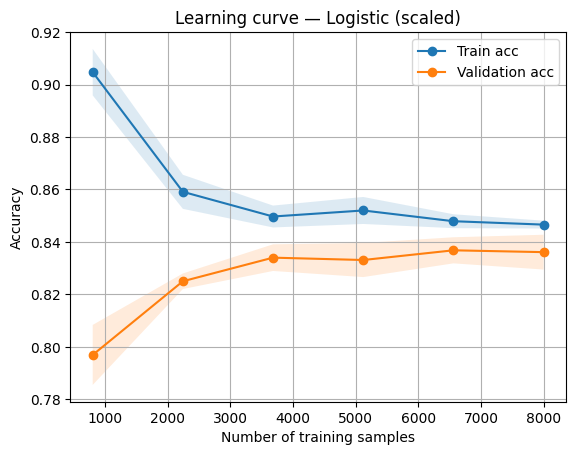

In [7]:
# === Cell A: overfitting diagnostics (learning curve) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def diagnose_overfitting(
    X, y,
    cv_splits: int = 5,
    train_sizes = np.linspace(0.1, 1.0, 6),
    random_state: int = 42,
    max_iter: int = 1000,
    plot: bool = True
):
    """
    Computes a learning curve for a Logistic Regression pipeline (Scaler + Logistic).
    Returns a dict with summary stats and optionally plots train vs validation accuracy.
    """
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=max_iter, random_state=random_state))
    ])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # learning_curve supports shuffle/random_state in recent sklearn versions
    ts_abs, train_scores, val_scores = learning_curve(
        estimator=pipe,
        X=X, y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring="accuracy",
        shuffle=True,
        random_state=random_state,
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    # Table view
    df_lc = pd.DataFrame({
        "train_size": ts_abs,
        "train_acc_mean": train_mean,
        "train_acc_std": train_std,
        "val_acc_mean": val_mean,
        "val_acc_std": val_std,
        "gap_train_minus_val": train_mean - val_mean
    })
    display(df_lc)

    # Simple decision rule for potential overfitting (gap at largest size)
    gap_last = float(df_lc["gap_train_minus_val"].iloc[-1])
    val_last = float(df_lc["val_acc_mean"].iloc[-1])
    flag_overfit = (gap_last >= 0.05) and (val_last < 0.80 or gap_last > 0.07)

    print(f"\nLargest train size = {int(ts_abs[-1])}")
    print(f"  • Train acc (mean): {train_mean[-1]:.4f}")
    print(f"  • Val   acc (mean): {val_mean[-1]:.4f}")
    print(f"  • Gap (train - val): {gap_last:.4f}")
    print(f"\nPotential overfitting: {'YES' if flag_overfit else 'NO'}")

    if plot:
        plt.figure()
        plt.plot(ts_abs, train_mean, marker="o", label="Train acc")
        plt.fill_between(ts_abs, train_mean-train_std, train_mean+train_std, alpha=0.15)
        plt.plot(ts_abs, val_mean, marker="o", label="Validation acc")
        plt.fill_between(ts_abs, val_mean-val_std, val_mean+val_std, alpha=0.15)
        plt.xlabel("Number of training samples")
        plt.ylabel("Accuracy")
        plt.title("Learning curve — Logistic (scaled)")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "train_sizes": ts_abs,
        "train_acc_mean": train_mean,
        "val_acc_mean": val_mean,
        "gap_last": gap_last,
        "val_last": val_last,
        "overfitting_flag": flag_overfit
    }

# --- How to call (run after Cell 2) ---
features = [c for c in train_df.columns if c not in ("battle_id", "player_won")]
X = train_df[features].values
y = train_df["player_won"].values
_ = diagnose_overfitting(X, y, cv_splits=5, max_iter=1000, plot=True)


# 3. Models Training

In [8]:
from sklearn.linear_model import LogisticRegression

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
y_train = train_df['player_won']

X_test = test_df[features]

# Initialize and train the model
print("Training a simple Logistic Regression model...")
model = LogisticRegression(random_state=42, max_iter=3000)
model.fit(X_train, y_train)
print("Model training complete.")

Training a simple Logistic Regression model...
Model training complete.


## 3.2 Best-features selection

In [9]:
import numpy as np
import pandas as pd

def drop_high_correlation(df: pd.DataFrame, threshold: float = 0.92):
    """
    Remove one feature from each highly-correlated pair (|corr| > threshold).
    Returns (reduced_df, dropped_by_corr, dropped_constants).
    """
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.replace([np.inf, -np.inf], np.nan)

    # drop constants
    const_mask = num.nunique(dropna=True) <= 1
    dropped_constants = list(num.columns[const_mask])
    num = num.drop(columns=dropped_constants)

    if num.shape[1] == 0:
        return df.drop(columns=dropped_constants, errors="ignore"), [], dropped_constants

    corr = num.corr().abs().fillna(0.0)
    upper = np.triu(np.ones_like(corr, dtype=bool), k=1)

    to_drop = []
    cols = corr.columns.to_list()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            if upper[i, j] and corr.iat[i, j] > threshold:
                # drop the j-th feature (arbitrary but consistent)
                col_j = cols[j]
                if col_j not in to_drop:
                    to_drop.append(col_j)

    reduced = df.drop(columns=set(dropped_constants) | set(to_drop), errors="ignore")
    return reduced, to_drop, dropped_constants

# --- Apply to TRAIN (features only) and align TEST ---
features_only = train_df.drop(columns=["battle_id", "player_won"]).copy()
train_reduced, dropped_corr, dropped_const = drop_high_correlation(features_only, threshold=0.92)
test_reduced  = test_df[train_reduced.columns].copy()

print(f"Feature count before: {features_only.shape[1]}")
print(f"Removed constants   : {len(dropped_const)}")
print(f"Removed by corr     : {len(dropped_corr)}  (thr=0.92)")
print(f"Feature count after : {train_reduced.shape[1]}")




Feature count before: 258
Removed constants   : 33
Removed by corr     : 42  (thr=0.92)
Feature count after : 183


## 3.3 Logistic Regression, with L1 penalization

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print("Evaluating Logistic Regression with L1 regularization...")

X = train_reduced
y = train_df["player_won"]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000,
                               random_state=42, class_weight='balanced')

logreg_l1.fit(X_train_split, y_train_split)
y_val_pred = logreg_l1.predict(X_val_split)
acc_val = accuracy_score(y_val_split, y_val_pred)

print(f"Validation Accuracy (L1): {acc_val:.4f}")

best_logreg = logreg_l1



Evaluating Logistic Regression with L1 regularization...
Validation Accuracy (L1): 0.8365


## 3.4- Keep only important features (based on L1 penalization)

In [11]:
# === 3.4 — L1-based feature selection + retrain (keeps notebook API intact) ===
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# y from original training frame (label stays out of any scaling/selection)
y = train_df["player_won"].values

# 1) Take absolute coefficients from the L1 model fitted in Cell 3.3
coef = best_logreg.coef_[0]
abs_coef = np.abs(coef)

# 2) Keep only features with non-trivial weight
#    You can nudge this threshold; 0.002–0.006 often works well.
thr = 0.003
keep_mask = abs_coef > thr
selected_features = list(train_reduced.columns[keep_mask])

print(f"[L1 selection] kept {len(selected_features)} / {len(train_reduced.columns)} features "
      f"(threshold={thr})")

# 3) Slice train/test with the selected columns (safe reindex for test)
X_train_sel = train_reduced[selected_features].copy()
X_test_sel  = test_reduced.reindex(columns=selected_features, fill_value=0).copy()

# 4) Retrain a slightly stronger-regularized L1 model on the selected features
#    (lower C => stronger sparsity; small boost against noise)
model_final = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=0.4,             # try 0.6 / 0.4 / 0.3 if you want tiny extra tweaks
    max_iter=3000,
    random_state=42
)
cv_acc = cross_val_score(model_final, X_train_sel, y, cv=5, scoring="accuracy")
print(f"[L1 selection] 5-fold CV accuracy: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")

model_final.fit(X_train_sel, y)

# 5) Keep notebook contract: downstream cells expect `model` and `features`
model = model_final
features = selected_features

# (Optional) quick sanity check on dimensions
print("Train shape:", X_train_sel.shape, "| Test shape:", X_test_sel.shape)

# 6) Also expose reduced matrices in case you want to reuse them explicitly
train_selected = X_train_sel
test_selected  = X_test_sel


[L1 selection] kept 141 / 183 features (threshold=0.003)
[L1 selection] 5-fold CV accuracy: 0.8385 ± 0.0052
Train shape: (10000, 141) | Test shape: (5000, 141)


## 3.5 KNN- "k" selection with CV

In [12]:
# === 3.5 KNN: pick K by CV ===
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

X = train_reduced
y = train_df["player_won"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

candidate_k = [3,5,7,9,11,13,15,17,21,25,31]
scores = {}
for k in candidate_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    acc = cross_val_score(knn, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
    scores[k] = acc
best_k = max(scores, key=scores.get)
print("KNN CV accuracies:", {k: round(v,4) for k,v in scores.items()})
print(f"Best K = {best_k} (CV acc={scores[best_k]:.4f})")

knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X, y)
knn_test_proba = knn_best.predict_proba(test_reduced)[:,1]


KNN CV accuracies: {3: 0.7118, 5: 0.7256, 7: 0.7338, 9: 0.7461, 11: 0.7535, 13: 0.7544, 15: 0.7534, 17: 0.7548, 21: 0.755, 25: 0.755, 31: 0.7571}
Best K = 31 (CV acc=0.7571)


## 3.6 Random Forest: shallow vs deep via CV

In [13]:
# === 3.6 Random Forest: shallow vs deep via CV ===
from sklearn.ensemble import RandomForestClassifier

rf_configs = {
    "shallow": RandomForestClassifier(
        n_estimators=400, max_depth=8, min_samples_split=4, min_samples_leaf=2,
        max_features="sqrt", random_state=42, n_jobs=-1
    ),
    "deep": RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        max_features="sqrt", random_state=42, n_jobs=-1
    ),
}
rf_cv_scores = {}
for name, model in rf_configs.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
    rf_cv_scores[name] = acc
best_rf_name = max(rf_cv_scores, key=rf_cv_scores.get)
print("RF CV accuracies:", {k: round(v,4) for k,v in rf_cv_scores.items()})
print(f"Best RF = {best_rf_name} (CV acc={rf_cv_scores[best_rf_name]:.4f})")

rf_best = rf_configs[best_rf_name]
rf_best.fit(X, y)
rf_test_proba = rf_best.predict_proba(test_reduced)[:,1]


RF CV accuracies: {'shallow': 0.8178, 'deep': 0.8243}
Best RF = deep (CV acc=0.8243)


## 3.7- XGBoost


In [14]:
# === 3.7 XGBoost (accuracy via CV) ===
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist",           
    n_jobs=-1
)

xgb_acc = cross_val_score(xgb_clf, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
print(f"XGB CV accuracy: {xgb_acc:.4f}")

xgb_clf.fit(X, y)
xgb_test_proba = xgb_clf.predict_proba(test_reduced)[:,1]


XGB CV accuracy: 0.8363


## 3.8 - Stacking Ensemble (OOF clean)


In [15]:
# === 3.8 Stacking Ensemble (OOF clean) ===
from sklearn.linear_model import LogisticRegression
import numpy as np

# Base 1: Logistic L1
log_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42)

# OOF containers
oof_log = np.zeros(len(X))
oof_rf  = np.zeros(len(X))
oof_knn = np.zeros(len(X))
oof_xgb = np.zeros(len(X))

for tr_idx, va_idx in cv.split(X, y):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr       = y.iloc[tr_idx]

    # Fit on fold
    log_l1.fit(X_tr, y_tr)
    rf_best.fit(X_tr, y_tr)
    knn_best.fit(X_tr, y_tr)
    xgb_clf.fit(X_tr, y_tr)

    # OOF preds
    oof_log[va_idx] = log_l1.predict_proba(X_va)[:,1]
    oof_rf[va_idx]  = rf_best.predict_proba(X_va)[:,1]
    oof_knn[va_idx] = knn_best.predict_proba(X_va)[:,1]
    oof_xgb[va_idx] = xgb_clf.predict_proba(X_va)[:,1]

# Meta-training set = OOF concatenation
stack_train = np.vstack([oof_log, oof_rf, oof_knn, oof_xgb]).T

# Meta-learner: Logistic
meta = LogisticRegression(penalty='l2', C=1.0, max_iter=2000, random_state=42)
meta.fit(stack_train, y)

# Fit base models on ALL data per test
log_l1.fit(X, y)
rf_best.fit(X, y)
knn_best.fit(X, y)
xgb_clf.fit(X, y)

# Test meta-input
log_test = log_l1.predict_proba(test_reduced)[:,1]
rf_test  = rf_best.predict_proba(test_reduced)[:,1]
knn_test = knn_best.predict_proba(test_reduced)[:,1]
xgb_test = xgb_clf.predict_proba(test_reduced)[:,1]

stack_test = np.vstack([log_test, rf_test, knn_test, xgb_test]).T
stack_pred_labels = meta.predict(stack_test)       
stack_pred_scores = meta.predict_proba(stack_test)[:,1]  
print("✅ Stacking (LogL1 + RF + KNN + XGB → Logistic meta) pronto.")

✅ Stacking (LogL1 + RF + KNN + XGB → Logistic meta) pronto.


## 3.9 - Threshold tuning (on OOF for the stacking meta-model)

In [16]:
# === 3.9 Threshold tuning (on OOF for the stacking meta-model) ===
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Safety checks
for var in ["stack_train", "stack_test", "y", "meta"]:
    if var not in globals():
        raise RuntimeError(f"Variable '{var}' is missing. Run the stacking cell (3.8) first.")

# Build OOF probabilities for the meta-learner to tune threshold without bias
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_meta_scores = np.zeros(len(stack_train))

for tr_idx, va_idx in cv.split(stack_train, y):
    X_tr, y_tr = stack_train[tr_idx], y.iloc[tr_idx]
    X_va       = stack_train[va_idx]
    # re-fit a fresh meta on the fold (same config as in 3.8)
    meta_fold = LogisticRegression(penalty="l2", C=1.0, max_iter=2000, random_state=42)
    meta_fold.fit(X_tr, y_tr)
    oof_meta_scores[va_idx] = meta_fold.predict_proba(X_va)[:, 1]

# Search best threshold on OOF scores
ths = np.arange(0.30, 0.71, 0.005)
accs = []
for t in ths:
    preds = (oof_meta_scores >= t).astype(int)
    accs.append(accuracy_score(y, preds))

best_idx = int(np.argmax(accs))
best_thr = float(ths[best_idx])
best_acc = float(accs[best_idx])

print(f"Best threshold on OOF = {best_thr:.3f} | OOF Accuracy = {best_acc:.4f}")

# Apply best threshold to TEST scores from the already-fitted meta (from 3.8)
# If you kept both:
#  - stack_pred_scores = meta.predict_proba(stack_test)[:,1]
#  - stack_pred_labels = meta.predict(stack_test)
if "stack_pred_scores" not in globals():
    # compute scores if not already present
    stack_pred_scores = meta.predict_proba(stack_test)[:, 1]

stack_pred_labels_tuned = (stack_pred_scores >= best_thr).astype(int)
print("✅ Created 'stack_pred_labels_tuned' using tuned threshold.")

# (Optional) quick table preview
import pandas as pd
display(pd.DataFrame({
    "threshold": ths,
    "oof_accuracy": accs
}).iloc[max(0, best_idx-5):best_idx+6].reset_index(drop=True))


Best threshold on OOF = 0.475 | OOF Accuracy = 0.8393
✅ Created 'stack_pred_labels_tuned' using tuned threshold.


,threshold,oof_accuracy
0,0.450,0.8381
1,0.455,0.8380
2,0.460,0.8385
3,0.465,0.8390
4,0.470,0.8387
5,0.475,0.8393
6,0.480,0.8390
7,0.485,0.8389
8,0.490,0.8388
9,0.495,0.8386


# 4. Creating the Submission File

In [17]:
# === Cell 4 — Submission (works with stacking + threshold tuning OR plain logistic) ===
import numpy as np
import pandas as pd

# Safety: check that we have test_df with battle_id
if "test_df" not in globals():
    raise RuntimeError("test_df is missing. Run Cells 1–2 first.")
if "battle_id" not in test_df.columns:
    raise RuntimeError("Column 'battle_id' not found in test_df.")

save_path = "/kaggle/working/submission.csv"

used_strategy = None

# 1) Preferred path: Stacking + (optionally) tuned threshold from Cell 3.9
if all(v in globals() for v in ["meta", "stack_test"]):
    print("Using STACKING meta-model for submission...")

    # If tuned labels already computed, reuse them
    if "stack_pred_labels_tuned" in globals():
        preds = stack_pred_labels_tuned.astype(int)
        used_strategy = "stacking (tuned threshold)"
    else:
        # If we have tuned threshold 'best_thr' and scores cached, apply it
        if "stack_pred_scores" in globals():
            thr = globals().get("best_thr", 0.5)
            preds = (stack_pred_scores >= float(thr)).astype(int)
            used_strategy = f"stacking (scores + thr={float(thr):.3f})"
        else:
            # Fall back to standard 0.5 on fresh scores
            scores = meta.predict_proba(stack_test)[:, 1]
            thr = float(globals().get("best_thr", 0.5))
            preds = (scores >= thr).astype(int)
            used_strategy = f"stacking (fresh scores + thr={thr:.3f})"

# 2) Fallback: Logistic L1 su feature ridotte (Cell 3.3 + 3.2)
elif all(v in globals() for v in ["best_logreg", "test_reduced"]):
    print("Using best L1-Logistic on reduced features for submission...")
    preds = best_logreg.predict(test_reduced).astype(int)
    used_strategy = "logistic L1 (reduced features)"

# 3) Last resort: simple logistic 'model' trained on all features (Cell 3 base)
elif all(v in globals() for v in ["model", "train_df"]):
    print("Using baseline Logistic (no reduction) for submission...")
    features = [c for c in test_df.columns if c not in ("battle_id", "player_won")]
    if hasattr(model, "predict"):
        preds = model.predict(test_df[features]).astype(int)
        used_strategy = "baseline logistic"
    else:
        raise RuntimeError("Baseline 'model' available but has no predict().")

else:
    raise RuntimeError(
        "No trained model found for submission. "
        "Run either the stacking cells (3.5–3.8 & 3.9) or the logistic cells (3–3.3)."
    )

# Build and save submission
submission = pd.DataFrame({
    "battle_id": test_df["battle_id"].astype(int),
    "player_won": preds.astype(int)
})

submission.to_csv(save_path, index=False)
print(f"✅ Submission saved to {save_path}")
print(f"Strategy used: {used_strategy}")
display(submission.head())

Using STACKING meta-model for submission...
✅ Submission saved to /kaggle/working/submission.csv
Strategy used: stacking (tuned threshold)


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


### 5. Submitting Your Results

Once you have generated your `submission.csv` file, there are two primary ways to submit it to the competition.

---

#### Method A: Submitting Directly from the Notebook

This is the standard method for code competitions. It ensures that your submission is linked to the code that produced it, which is crucial for reproducibility.

1.  **Save Your Work:** Click the **"Save Version"** button in the top-right corner of the notebook editor.
2.  **Run the Notebook:** In the pop-up window, select **"Save & Run All (Commit)"** and then click the **"Save"** button. This will run your entire notebook from top to bottom and save the output, including your `submission.csv` file.
3.  **Go to the Viewer:** Once the save process is complete, navigate to the notebook viewer page. 
4.  **Submit to Competition:** In the viewer, find the **"Submit to Competition"** section. This is usually located in the header of the output section or in the vertical "..." menu on the right side of the page. Clicking the **Submit** button this will submit your generated `submission.csv` file.

After submitting, you will see your score in the **"Submit to Competition"** section or in the [Public Leaderboard](https://www.kaggle.com/competitions/fds-pokemon-battles-prediction-2025/leaderboard?).

---

#### Method B: Manual Upload

You can also generate your predictions and submission file using any environment you prefer (this notebook, Google Colab, or your local machine).

1.  **Generate the `submission.csv` file** using your model.
2.  **Download the file** to your computer.
3.  **Navigate to the [Leaderboard Page](https://www.kaggle.com/competitions/fds-pokemon-battles-prediction-2025/leaderboard?)** and click on the **"Submit Predictions"** button.
4.  **Upload Your File:** Drag and drop or select your `submission.csv` file to upload it.

This method is quick, but keep in mind that for the final evaluation, you might be required to provide the code that generated your submission.

Good luck!